In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import fooof
from fooof import FOOOFGroup
import os 
import joblib
import emd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pickle
from tqdm import tqdm
from IPython.display import clear_output


Note: If you have installed this package in editable form on Minerva, you must append the local path! This is because Minerva requires that you point your package installs away from the local directory for space reasons, but editable packages have to be installed locally.

In [5]:
import sys
sys.path.append('/hpc/users/qasims01/resources/LFPAnalysis')

In [6]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils, oscillation_utils

In [7]:
import h5io

## First, get the behavior data

This is from another notebook with a kernel and environment specifically for beahvior

In [8]:
base_dir = '/sc/arion' # this is the root directory for most un-archived data and results
load_dir = f'{base_dir}/work/qasims01/MemoryBanditData/EMU'
full_data = pd.read_csv(f'{load_dir}/full_df.csv')
learn_df = pd.read_csv(f'{load_dir}/learn_df.csv')
combined_df = pd.read_csv(f'{load_dir}/combined_df.csv')

In [9]:
# Load the demographics data to get information about who has run the task
demo_file = f'{base_dir}/projects/guLab/Salman/EMU/MemoryBanditsDatabase.xlsx'
demo_data = pd.read_excel(demo_file, engine='openpyxl')
subj_df = demo_data[(demo_data.LongVersion==1) & (demo_data.Minerva==1)]

In [10]:
# # Check that the subjects in subj_df are all accounted for in behavior
# subj_df.MSSMCode.values

In [11]:
# Let's get rid of Iowa patients for now 

subj_df = subj_df[subj_df.Site!='UI']

# Let's get rid of the person with no photodiode 

# subj_df = subj_df[subj_df.MSSMCode!='MS022']


In [12]:
subj_df

Site MSSMCode  OtherCodes  Day1  Day2  LongVersion      Date1  \
3   MSSM    MS012         NaN     1     0            1 2022-08-10   
5   MSSM    MS015         NaN     1     1            1 2022-09-24   
6   MSSM    MS016         NaN     1     1            1 2022-09-24   
7   MSSM    MS017         NaN     1     1            1 2022-10-05   
9   MSSM    MS019         NaN     1     1            1 2022-12-01   
10  MSSM    MS020         NaN     1     1            1 2023-02-02   
11  MSSM    MS022         NaN     1     0            1 2023-02-05   
12  MSSM    MS023         NaN     1     1            1 2023-02-21   
14  MSSM    MS024         NaN     1     1            1 2023-03-01   
15  MSSM    MS025         NaN     1     1            1 2023-03-09   
16  MSSM    MS026         NaN     1     1            1 2023-03-23   
17  MSSM    MS028         NaN     1     0            1 2023-04-05   
18  MSSM    MS030         NaN     1     1            1 2023-06-07   
21  MSSM    MS034         NaN     1     0            1 2023-08-04   
22  MSSM    MS035         NaN     1     1            1        NaT   
23  MSSM    MS036         NaN     1     1            1 2023-08-16   

          Experimenter  Micros  Resp  ... Minerva   Age   BDI   BAI  IQ  \
3              Lizbeth     0.0     0  ...       1  20.0   NaN   NaN NaN   
5     Salman + Lizbeth     0.0     0  ...       1  33.0   8.0   0.0 NaN   
6     Salman + Lizbeth     0.0     0  ...       1  24.0   1.0   0.0 NaN   
7     Salman + Lizbeth     0.0     0  ...       1  26.0  22.0  29.0 NaN   
9              Lizbeth     0.0     0  ...       1  56.0  23.0  13.0 NaN   
10             Lizbeth     1.0     0  ...       1  31.0  24.0  14.0 NaN   
11    Lizbeth + Jackie     1.0     0  ...       1  65.0  10.0  12.0 NaN   
12             Lizbeth     0.0     0  ...       1  52.0   6.0   4.0 NaN   
14             Lizbeth     1.0     0  ...       1  32.0   NaN   NaN NaN   
15  Christina + Jackie     1.0     0  ...       1  38.0   3.0  10.0 NaN   
16              Salman     1.0     1  ...       1  49.0  18.0  30.0 NaN   
17             Lizbeth     1.0     0  ...       1  32.0   2.0  12.0 NaN   
18             Lizbeth     1.0     0  ...       1   NaN   NaN   NaN NaN   
21                Alie     0.0     0  ...       1   NaN   NaN   NaN NaN   
22             Lizbeth     0.0     0  ...       1   NaN   NaN   NaN NaN   
23             Lizbeth     0.0     0  ...       1  17.0   NaN   NaN NaN   

    Education  Handedness  Sex              Race       Ethnicity  
3         NaN           R   F              White    Not Hispanic  
5         NaN           R    F  African-American    Not Hispanic  
6         NaN           R    F               NaN        Hispanic  
7         NaN           R    F             Other  Latin-American  
9         NaN           R    M             White             NaN  
10        NaN           R    F               NaN             NaN  
11        NaN           R    M               NaN             NaN  
12        NaN         NaN    M               NaN             NaN  
14        NaN         NaN    M  African-American    Not Hispanic  
15        NaN         NaN    F             White    Not Hispanic  
16        NaN         NaN    F            White     Puerto Rican  
17        NaN         NaN    F  African-American    Not Hispanic  
18        NaN         NaN  NaN               NaN             NaN  
21        NaN         NaN  NaN               NaN             NaN  
22        NaN         NaN  NaN               NaN             NaN  
23        NaN         NaN  NaN               NaN             NaN  

[16 rows x 25 columns]

## Test out the .ncs code for duplicates

In [12]:
# import re

# path_to_data = f'{base_dir}/projects/guLab/Salman/EMU/MS003/test/'

# pattern = re.compile(r"_\d{4}\.ncs") 
# # This is dumb. We should sort them, load the ones that load (some don't have data), and concatenate them all. Once again, stupid.

# # First, let's list the files wihout a number attached. This always comes first: 
# ncs_files = [x for x in glob(f'{path_to_data}/*.ncs') if re.search(pattern, x)]



In [13]:

# # Second, let's compile a dictionary for each of these, listing out it's duplicates
# duplicates_dict = {f'{os.path.split(ncs_files[0])[-1][:-4]}':[ncs_files[0]] for x in ncs_files}

# for filename in ncs_files: 
#     chan_name = os.path.split(ncs_files[0])[-1][:-4]
#     list_concat_chans = [x for x in glob(f'{path_to_data}/*.ncs') if re.search(pattern, x)]
#     list_concat_chans = [x for x in list_concat_chans if chan_name in x]
#     for duplicate_file in list_concat_chans:
#         try:
#             test_load = nlx_utils.load_ncs(duplicate_file)
#             # If it loads ok, do nothing
#         except: 
#             # If it fails to load, remove it from the list
#             list_concat_chans.remove(duplicate_file)

#     duplicates_dict[chan_name]+=list_concat_chans

In [127]:
# test_load1 = nlx_utils.load_ncs(ncs_files[0])
# test_load2 = nlx_utils.load_ncs(ncs_files[1])


In [128]:
# 3529669333/1000000/60

## Load, pre-process and re-reference the neural data

In [13]:
days = ['Day1', 'Day2']
subj_ids = subj_df.MSSMCode.values
subj_formats = subj_df.format.values
subj_sites = subj_df.Site.values
subj_days = subj_df.Day2.values

In [14]:
subj_ids

array(['MS012', 'MS015', 'MS016', 'MS017', 'MS019', 'MS020', 'MS022',
       'MS023', 'MS024', 'MS025', 'MS026', 'MS028', 'MS030', 'MS034',
       'MS035', 'MS036'], dtype=object)

Run the initial loading and 

In [211]:

for ix, subj_id in enumerate(subj_ids[:-1]): 
    site = subj_sites[:-1][ix]
    format = subj_formats[:-1][ix]
    for day in days:
        # Check if this day is in the dataset:
        if subj_df[subj_df.MSSMCode==subj_id][day].values[0] == 0:
            print (f'subject {subj_id} does not have Day 2 data')
            continue
        else:
            print(f'Working on subj {subj_id}')
            # Set paths
            load_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/neural/{day}'
            elec_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/anat/'
            save_path = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}/neural/{day}'
            # Check if path exists for saving, and if not, make it
            if not os.path.exists(save_path):
                os.makedirs(save_path)

            # electrode files could either be csv or excel
            elec_files = glob(f'{elec_path}/*.csv') + glob(f'{elec_path}/*.xlsx')
            # There should really only be one, so grab it with the zero-index 
            elec_file = elec_files[0]

            # Make MNE file
            mne_data = lfp_preprocess_utils.make_mne(load_path=load_path, 
                                                     elec_path=elec_file,
                                                     format=format,
                                                     return_data=True,
                                                     site=site)
            
            # Save this data so that you don't need this step again:
            mne_data.save(f'{save_path}/raw_ieeg.fif', overwrite=True)


Working on subj MS012


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1023: UserWarning: No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out
  warnings.warn(f'No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out')
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1054: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS012/neural/Day1/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save(f'{load_path}/photodiode.fif', picks=sync_name, overwrite=overwrite)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 276 out of 276 | elapsed:    8.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 104 out of 104 | elapsed:    2.7s finished
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysi

subject MS012 does not have Day 2 data
Working on subj MS015


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1023: UserWarning: No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out
  warnings.warn(f'No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out')
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1054: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS015/neural/Day1/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save(f'{load_path}/photodiode.fif', picks=sync_name, overwrite=overwrite)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 148 out of 148 | elapsed:    8.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.7s finished
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysi

Working on subj MS015


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1023: UserWarning: No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out
  warnings.warn(f'No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out')
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1054: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS015/neural/Day2/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save(f'{load_path}/photodiode.fif', picks=sync_name, overwrite=overwrite)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 148 out of 148 | elapsed:    8.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.9s finished
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysi

Working on subj MS016


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1023: UserWarning: No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out
  warnings.warn(f'No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out')
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1054: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS016/neural/Day1/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save(f'{load_path}/photodiode.fif', picks=sync_name, overwrite=overwrite)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 276 out of 276 | elapsed:   17.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 122 out of 122 | elapsed:    9.4s finished
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysi

Working on subj MS016


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1023: UserWarning: No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out
  warnings.warn(f'No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out')
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1054: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS016/neural/Day2/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save(f'{load_path}/photodiode.fif', picks=sync_name, overwrite=overwrite)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0

Number of electrodes in the mne file is greater than the number of electrodes in the localization file


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 276 out of 276 | elapsed:    7.7s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 122 out of 122 | elapsed:    3.3s finished
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1092: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS016/neural/Day2/lfp_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg

Working on subj MS017


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1023: UserWarning: No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out
  warnings.warn(f'No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out')
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1036: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  mne_data = mne.io.read_raw_edf(edf_file, preload=True)
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1054: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS017/neural/Day1/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw

Number of electrodes in the mne file is greater than the number of electrodes in the localization file


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 276 out of 276 | elapsed:    9.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    2.8s finished
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1092: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS017/neural/Day1/lfp_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg

Working on subj MS017


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1023: UserWarning: No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out
  warnings.warn(f'No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out')
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1054: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS017/neural/Day2/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save(f'{load_path}/photodiode.fif', picks=sync_name, overwrite=overwrite)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 276 out of 276 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.3s finished
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysi

Working on subj MS019


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1023: UserWarning: No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out
  warnings.warn(f'No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out')
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1036: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  mne_data = mne.io.read_raw_edf(edf_file, preload=True)
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1054: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS019/neural/Day1/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw

Number of electrodes in the mne file is greater than the number of electrodes in the localization file


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 276 out of 276 | elapsed:   19.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 170 out of 170 | elapsed:   13.0s finished
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysi

Working on subj MS019


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1023: UserWarning: No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out
  warnings.warn(f'No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out')
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1036: RuntimeWarning: Number of records from the header does not match the file size (perhaps the recording was not stopped before exiting). Inferring from the file size.
  mne_data = mne.io.read_raw_edf(edf_file, preload=True)
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1054: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS019/neural/Day2/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw

Number of electrodes in the mne file is greater than the number of electrodes in the localization file


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 276 out of 276 | elapsed:   10.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 170 out of 170 | elapsed:    4.6s finished
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysi

Working on subj MS020


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1023: UserWarning: No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out
  warnings.warn(f'No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out')
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1054: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS020/neural/Day1/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save(f'{load_path}/photodiode.fif', picks=sync_name, overwrite=overwrite)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0

Number of electrodes in the mne file is greater than the number of electrodes in the localization file


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 276 out of 276 | elapsed:   12.4s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:   11.1s finished
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1092: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS020/neural/Day1/lfp_data.fif) does not conform to MNE naming

Working on subj MS020


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1023: UserWarning: No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out
  warnings.warn(f'No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out')
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1054: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS020/neural/Day2/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save(f'{load_path}/photodiode.fif', picks=sync_name, overwrite=overwrite)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 276 out of 276 | elapsed:    8.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    3.7s finished
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysi

Working on subj MS022


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1023: UserWarning: No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out
  warnings.warn(f'No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out')
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1054: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS022/neural/Day1/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save(f'{load_path}/photodiode.fif', picks=sync_name, overwrite=overwrite)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 148 out of 148 | elapsed:   14.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   23.1s finished
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1092: RuntimeWarning: This filename (/sc/arion/projects

subject MS022 does not have Day 2 data
Working on subj MS023


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1023: UserWarning: No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out
  warnings.warn(f'No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out')
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1054: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS023/neural/Day1/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save(f'{load_path}/photodiode.fif', picks=sync_name, overwrite=overwrite)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 276 out of 276 | elapsed:   20.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 174 out of 174 | elapsed:   13.9s finished
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1092: RuntimeWarning: This filename (/sc/arion/projects

Working on subj MS023


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1023: UserWarning: No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out
  warnings.warn(f'No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out')
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1054: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS023/neural/Day2/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save(f'{load_path}/photodiode.fif', picks=sync_name, overwrite=overwrite)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0

Number of electrodes in the mne file is greater than the number of electrodes in the localization file


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 276 out of 276 | elapsed:   16.2s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 174 out of 174 | elapsed:   14.1s finished
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1092: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS023/neural/Day2/lfp_data.fif) does not conform to MNE naming

Working on subj MS024


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1023: UserWarning: No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out
  warnings.warn(f'No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out')
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1054: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS024/neural/Day1/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save(f'{load_path}/photodiode.fif', picks=sync_name, overwrite=overwrite)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0

Number of electrodes in the mne file is greater than the number of electrodes in the localization file


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 276 out of 276 | elapsed:    7.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 158 out of 158 | elapsed:    4.3s finished
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1092: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS024/neural/Day1/lfp_data.fif) does not conform to MNE naming

Working on subj MS024


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1023: UserWarning: No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out
  warnings.warn(f'No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out')
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1054: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS024/neural/Day2/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save(f'{load_path}/photodiode.fif', picks=sync_name, overwrite=overwrite)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0

Number of electrodes in the mne file is greater than the number of electrodes in the localization file


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 276 out of 276 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 158 out of 158 | elapsed:    1.9s finished
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1092: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS024/neural/Day2/lfp_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg

Working on subj MS025


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1023: UserWarning: No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out
  warnings.warn(f'No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out')
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1054: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS025/neural/Day1/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save(f'{load_path}/photodiode.fif', picks=sync_name, overwrite=overwrite)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 276 out of 276 | elapsed:   12.0s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:   13.8s finished
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysi

Working on subj MS025


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1023: UserWarning: No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out
  warnings.warn(f'No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out')
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1054: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS025/neural/Day2/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save(f'{load_path}/photodiode.fif', picks=sync_name, overwrite=overwrite)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 276 out of 276 | elapsed:   17.1s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:   13.7s finished
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysi

Working on subj MS026


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1023: UserWarning: No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out
  warnings.warn(f'No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out')
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:156: UserWarning: Invalid samples in one or more records
  warnings.warn('Invalid samples in one or more records')
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:183: UserWarning: Unable to rescale data, no ADBitVolts value specified in header
  warnings.warn('Unable to rescale data, no ADBitVolts value specified in header')


Data in numbered files
Unidentified data type in BLANK2
Unidentified data type in CHEST1
Unidentified data type in ABS2
Unidentified data type in ABS1
Unidentified data type in Mic
Unidentified data type in Audio
Unidentified data type in Photodiode
Unidentified data type in BLANK1
Unidentified data type in EKG1
Unidentified data type in Analog5
Unidentified data type in CHEST2
Unidentified data type in EKG2
Unidentified data type in Photo
Unidentified data type in Analog6


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   22.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 187 out of 187 | elapsed:   26.3s finished


Saving photodiode data to /sc/arion/projects/guLab/Salman/EMU/MS026/neural/Day1/photodiode.fif
Saving EEG data to /sc/arion/projects/guLab/Salman/EMU/MS026/neural/Day1/scalp_eeg_data.fif


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1211: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS026/neural/Day1/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save(f'{load_path}/photodiode.fif', picks=sync_name, overwrite=overwrite)
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1228: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS026/neural/Day1/scalp_eeg_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save(f'{load_path}/scalp_eeg_data.fif', picks=eeg_names, overwrite=overwrite

Saving LFP data to /sc/arion/projects/guLab/Salman/EMU/MS026/neural/Day1/lfp_data.fif


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1254: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS026/neural/Day1/lfp_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save(f'{load_path}/lfp_data.fif', picks=seeg_names, overwrite=overwrite)


Working on subj MS026
Data in numbered files


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1023: UserWarning: No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out
  warnings.warn(f'No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out')
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:156: UserWarning: Invalid samples in one or more records
  warnings.warn('Invalid samples in one or more records')
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:183: UserWarning: Unable to rescale data, no ADBitVolts value specified in header
  warnings.warn('Unable to rescale data, no ADBitVolts value specified in header')


Unidentified data type in EKG2
Unidentified data type in Mic
Unidentified data type in Photodiode
Unidentified data type in CHEST1
Unidentified data type in BLANK2
Unidentified data type in Analog5
Unidentified data type in EKG1
Unidentified data type in ABS2
Unidentified data type in Analog6
Unidentified data type in BLANK1
Unidentified data type in CHEST2
Unidentified data type in Photo
Unidentified data type in Audio
Unidentified data type in ABS1


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   11.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   22.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  31 out of  31 | elapsed:  3.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 187 out of 187 | elapsed:   17.8s finished


Saving photodiode data to /sc/arion/projects/guLab/Salman/EMU/MS026/neural/Day2/photodiode.fif


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1211: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS026/neural/Day2/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save(f'{load_path}/photodiode.fif', picks=sync_name, overwrite=overwrite)


Saving EEG data to /sc/arion/projects/guLab/Salman/EMU/MS026/neural/Day2/scalp_eeg_data.fif


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1228: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS026/neural/Day2/scalp_eeg_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save(f'{load_path}/scalp_eeg_data.fif', picks=eeg_names, overwrite=overwrite)
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:   51.1s finished


Saving LFP data to /sc/arion/projects/guLab/Salman/EMU/MS026/neural/Day2/lfp_data.fif


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1254: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS026/neural/Day2/lfp_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save(f'{load_path}/lfp_data.fif', picks=seeg_names, overwrite=overwrite)


Working on subj MS028


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1023: UserWarning: No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out
  warnings.warn(f'No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out')
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:156: UserWarning: Invalid samples in one or more records
  warnings.warn('Invalid samples in one or more records')
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/nlx_utils.py:183: UserWarning: Unable to rescale data, no ADBitVolts value specified in header
  warnings.warn('Unable to rescale data, no ADBitVolts value specified in header')


Unidentified data type in BLANK2
Unidentified data type in Mic
Unidentified data type in Photo
Unidentified data type in BLANK1
Unidentified data type in Photodiode
Unidentified data type in EKG2
Unidentified data type in Audio
Unidentified data type in ABS2
Unidentified data type in CHEST1
Unidentified data type in CHEST2
Unidentified data type in EKG1
Unidentified data type in ABS1


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   11.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   17.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   22.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   57.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 181 out of 181 | elapsed:   19.9s finished


Saving photodiode data to /sc/arion/projects/guLab/Salman/EMU/MS028/neural/Day1/photodiode.fif


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1211: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS028/neural/Day1/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save(f'{load_path}/photodiode.fif', picks=sync_name, overwrite=overwrite)


Saving EEG data to /sc/arion/projects/guLab/Salman/EMU/MS028/neural/Day1/scalp_eeg_data.fif


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1228: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS028/neural/Day1/scalp_eeg_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save(f'{load_path}/scalp_eeg_data.fif', picks=eeg_names, overwrite=overwrite)


Number of electrodes in the mne file is less than the number of electrodes in the localization file


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:   49.0s finished


Saving LFP data to /sc/arion/projects/guLab/Salman/EMU/MS028/neural/Day1/lfp_data.fif


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1254: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS028/neural/Day1/lfp_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save(f'{load_path}/lfp_data.fif', picks=seeg_names, overwrite=overwrite)


subject MS028 does not have Day 2 data
Working on subj MS030


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1023: UserWarning: No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out
  warnings.warn(f'No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out')
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1054: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS030/neural/Day1/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save(f'{load_path}/photodiode.fif', picks=sync_name, overwrite=overwrite)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0

Number of electrodes in the mne file is greater than the number of electrodes in the localization file


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 276 out of 276 | elapsed:    9.5s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    3.4s finished
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1092: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS030/neural/Day1/lfp_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, 

Working on subj MS030


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1023: UserWarning: No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out
  warnings.warn(f'No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out')
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1054: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS030/neural/Day2/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save(f'{load_path}/photodiode.fif', picks=sync_name, overwrite=overwrite)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 276 out of 276 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    1.6s finished
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysi

Working on subj MS034


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1023: UserWarning: No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out
  warnings.warn(f'No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out')
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1054: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS034/neural/Day1/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save(f'{load_path}/photodiode.fif', picks=sync_name, overwrite=overwrite)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0

Number of electrodes in the mne file is greater than the number of electrodes in the localization file


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 276 out of 276 | elapsed:   10.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 156 out of 156 | elapsed:    3.9s finished
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1092: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS034/neural/Day1/lfp_data.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, 

subject MS034 does not have Day 2 data
Working on subj MS035


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1023: UserWarning: No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out
  warnings.warn(f'No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out')
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1054: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS035/neural/Day1/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save(f'{load_path}/photodiode.fif', picks=sync_name, overwrite=overwrite)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 276 out of 276 | elapsed:   13.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 172 out of 172 | elapsed:   13.1s finished
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysi

Working on subj MS035


/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1023: UserWarning: No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out
  warnings.warn(f'No sync name specified - if using an audiovisual sync signal please check load_path to make sure a valid sync was saved out')
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysis/lfp_preprocess_utils.py:1054: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS035/neural/Day2/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  mne_data.save(f'{load_path}/photodiode.fif', picks=sync_name, overwrite=overwrite)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 276 out of 276 | elapsed:    5.8s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 172 out of 172 | elapsed:    4.7s finished
/hpc/users/qasims01/resources/LFPAnalysis/LFPAnalysi

Manually annotate bad channels for each recording: 

In [212]:
subj_df

Site MSSMCode  OtherCodes  Day1  Day2  LongVersion      Date1  \
3   MSSM    MS012         NaN     1     0            1 2022-08-10   
5   MSSM    MS015         NaN     1     1            1 2022-09-24   
6   MSSM    MS016         NaN     1     1            1 2022-09-24   
7   MSSM    MS017         NaN     1     1            1 2022-10-05   
9   MSSM    MS019         NaN     1     1            1 2022-12-01   
10  MSSM    MS020         NaN     1     1            1 2023-02-02   
11  MSSM    MS022         NaN     1     0            1 2023-02-05   
12  MSSM    MS023         NaN     1     1            1 2023-02-21   
14  MSSM    MS024         NaN     1     1            1 2023-03-01   
15  MSSM    MS025         NaN     1     1            1 2023-03-09   
16  MSSM    MS026         NaN     1     1            1 2023-03-23   
17  MSSM    MS028         NaN     1     0            1 2023-04-05   
18  MSSM    MS030         NaN     1     1            1 2023-06-07   
21  MSSM    MS034         NaN     1     0            1 2023-08-04   
22  MSSM    MS035         NaN     1     1            1        NaT   
23  MSSM    MS036         NaN     1     1            1 2023-08-16   

          Experimenter  Micros  Resp  ... Minerva   Age   BDI   BAI  IQ  \
3              Lizbeth     0.0     0  ...       1  20.0   NaN   NaN NaN   
5     Salman + Lizbeth     0.0     0  ...       1  33.0   8.0   0.0 NaN   
6     Salman + Lizbeth     0.0     0  ...       1  24.0   1.0   0.0 NaN   
7     Salman + Lizbeth     0.0     0  ...       1  26.0  22.0  29.0 NaN   
9              Lizbeth     0.0     0  ...       1  56.0  23.0  13.0 NaN   
10             Lizbeth     1.0     0  ...       1  31.0  24.0  14.0 NaN   
11    Lizbeth + Jackie     1.0     0  ...       1  65.0  10.0  12.0 NaN   
12             Lizbeth     0.0     0  ...       1  52.0   6.0   4.0 NaN   
14             Lizbeth     1.0     0  ...       1  32.0   NaN   NaN NaN   
15  Christina + Jackie     1.0     0  ...       1  38.0   3.0  10.0 NaN   
16              Salman     1.0     1  ...       1  49.0  18.0  30.0 NaN   
17             Lizbeth     1.0     0  ...       1  32.0   2.0  12.0 NaN   
18             Lizbeth     1.0     0  ...       1   NaN   NaN   NaN NaN   
21                Alie     0.0     0  ...       1   NaN   NaN   NaN NaN   
22             Lizbeth     0.0     0  ...       1   NaN   NaN   NaN NaN   
23             Lizbeth     0.0     0  ...       1  17.0   NaN   NaN NaN   

    Education  Handedness  Sex              Race       Ethnicity  
3         NaN           R   F              White    Not Hispanic  
5         NaN           R    F  African-American    Not Hispanic  
6         NaN           R    F               NaN        Hispanic  
7         NaN           R    F             Other  Latin-American  
9         NaN           R    M             White             NaN  
10        NaN           R    F               NaN             NaN  
11        NaN           R    M               NaN             NaN  
12        NaN         NaN    M               NaN             NaN  
14        NaN         NaN    M  African-American    Not Hispanic  
15        NaN         NaN    F             White    Not Hispanic  
16        NaN         NaN    F            White     Puerto Rican  
17        NaN         NaN    F  African-American    Not Hispanic  
18        NaN         NaN  NaN               NaN             NaN  
21        NaN         NaN  NaN               NaN             NaN  
22        NaN         NaN  NaN               NaN             NaN  
23        NaN         NaN  NaN               NaN             NaN  

[16 rows x 25 columns]

In [34]:
%matplotlib notebook 
# Note: this does not work in JupyterLAB.

<IPython.core.display.Javascript object>


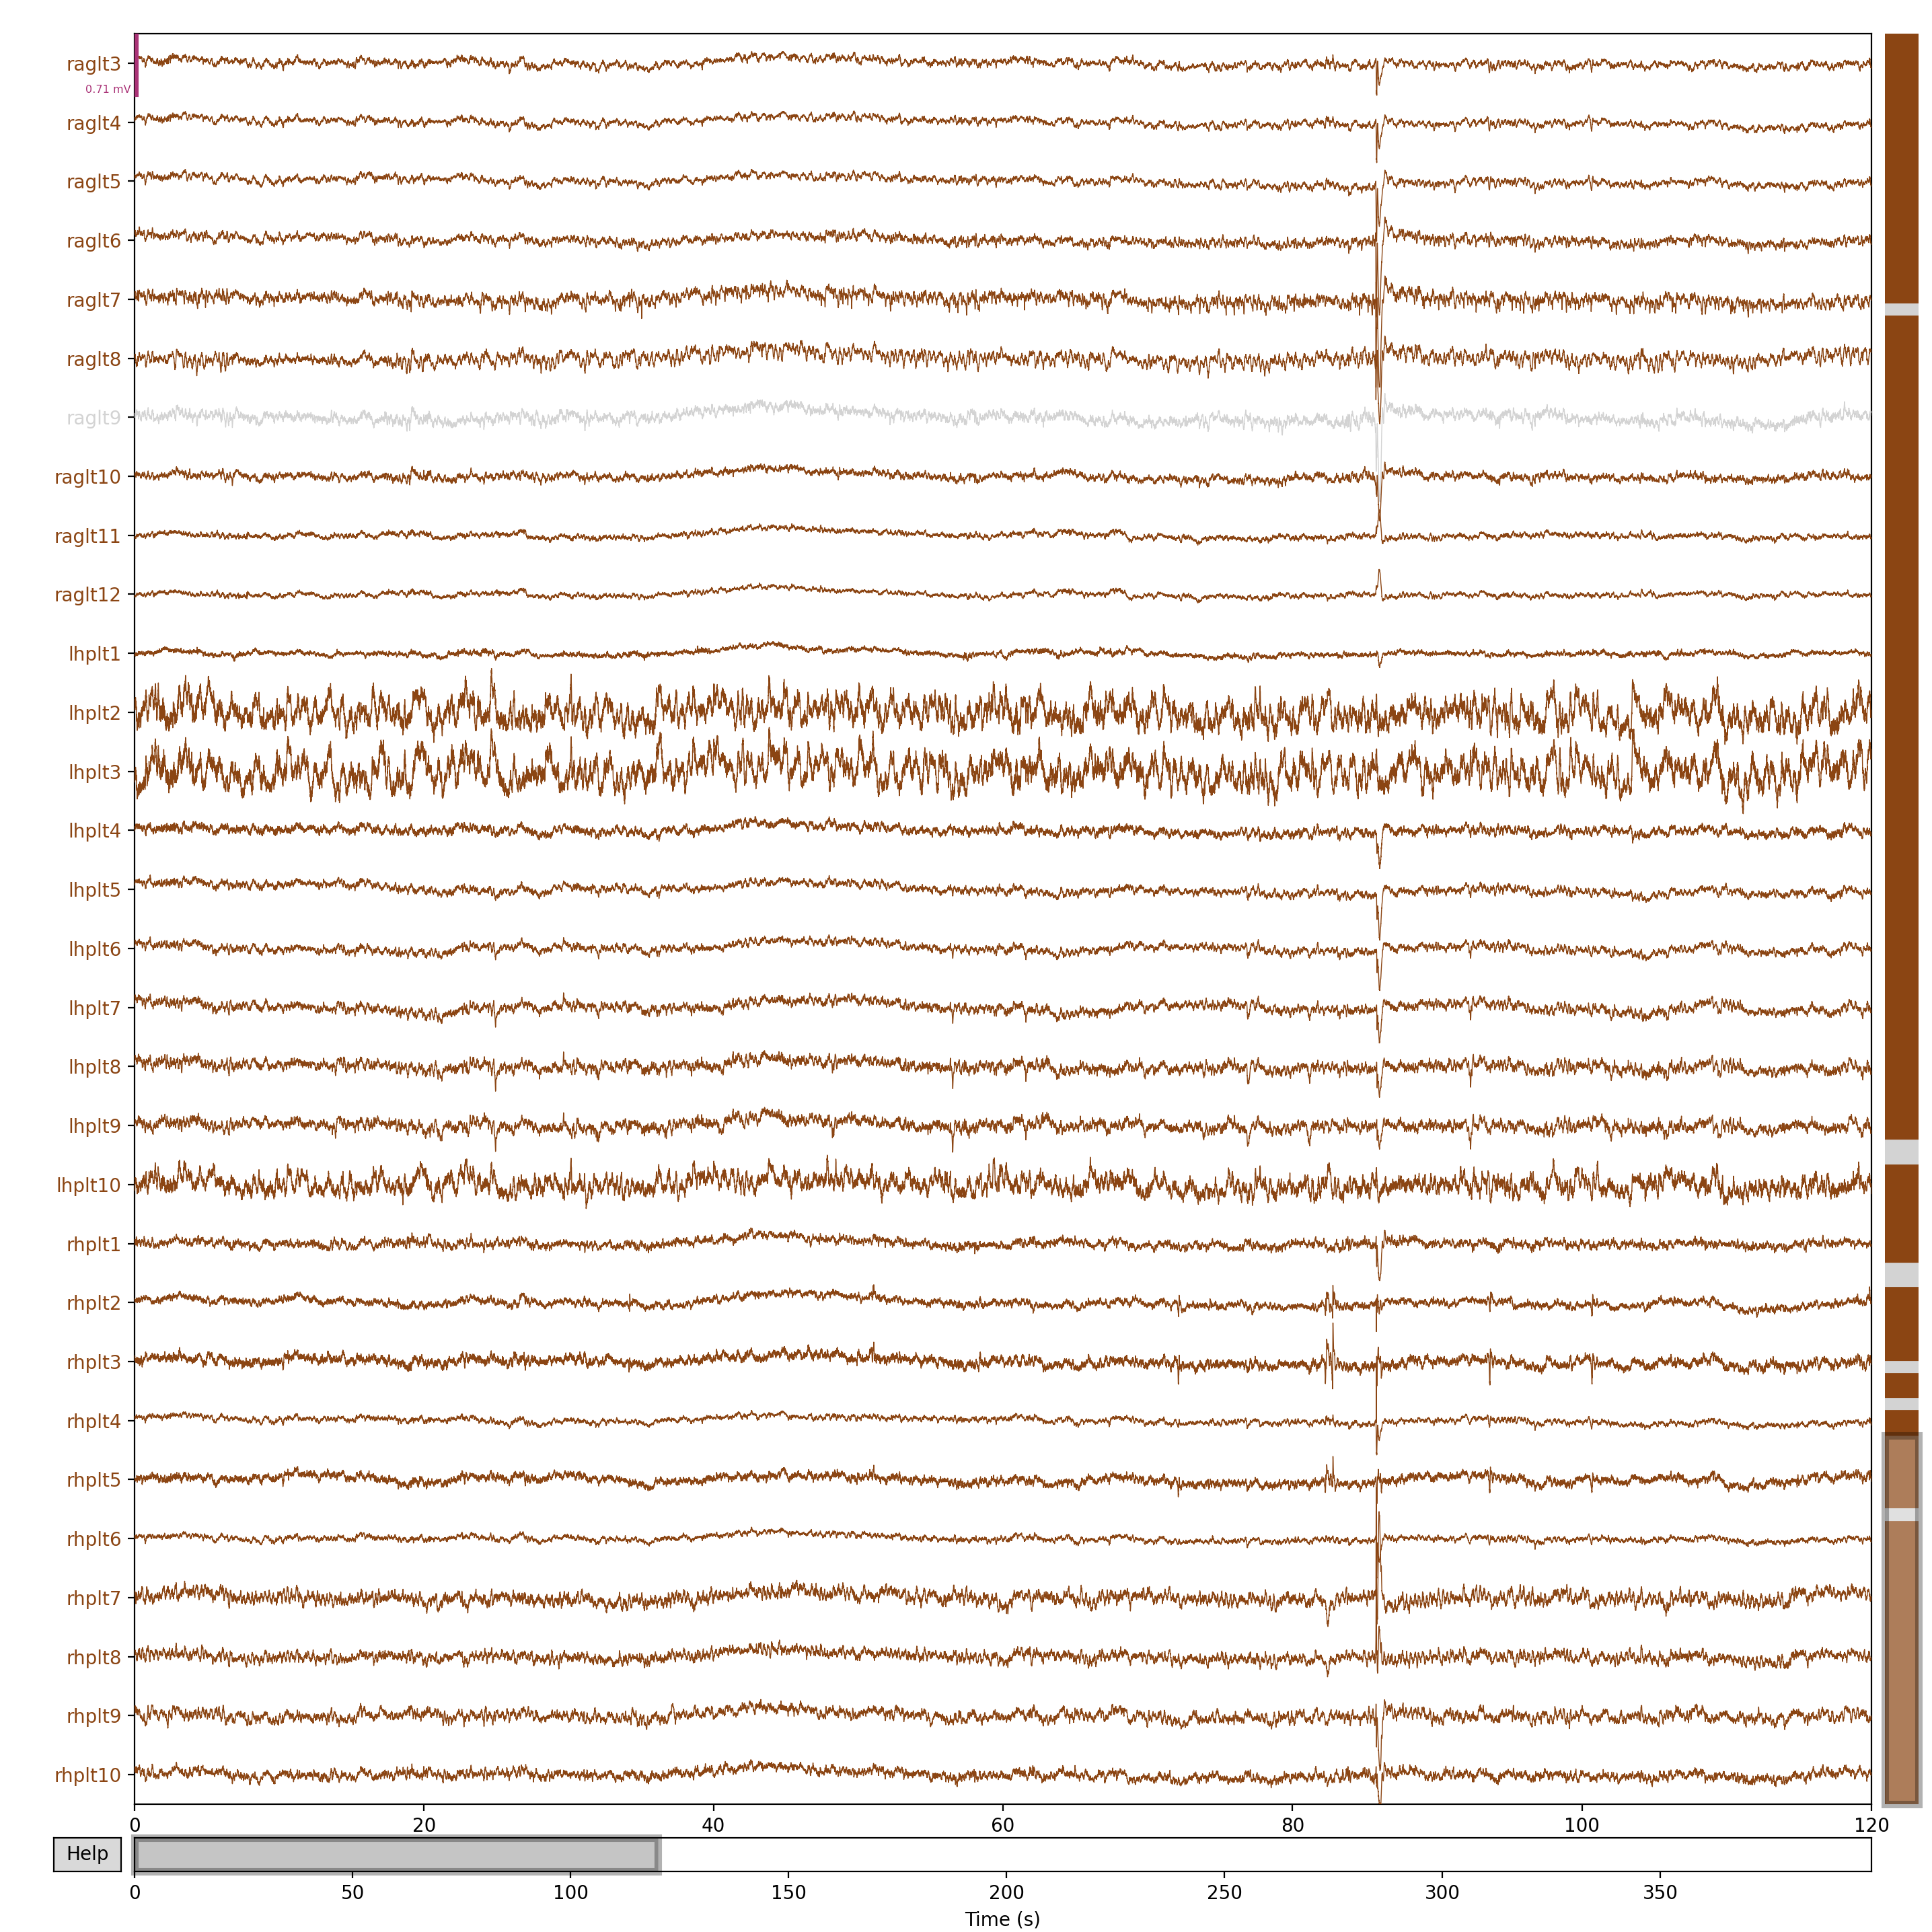

In [281]:
subj_id = 'MS036'
day = 'Day2'
save_path = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}/neural/{day}'
mne_data = mne.io.read_raw_fif(f'{save_path}/raw_ieeg.fif', preload=True)
fig = mne_data.plot(start=0, duration=120, n_channels=30, 
                      scalings=mne_data._data.max()/30
                     )

In [282]:
# Save this manual data
mne_data.save(f'{save_path}/raw_ieeg.fif', overwrite=True)

Test out the Bipolar reference

In [283]:
for ix, subj_id in enumerate(subj_ids): 
    site = subj_sites[ix]
    format = subj_formats[ix]
    for day in days:
        # Check if this day is in the dataset:
        if subj_df[day].values[ix] == 0:
            print (f'subject {subj_id} does not have Day 2 data')
            continue
        else:
            print(f'Working on subj {subj_id}')
            # Set paths
            load_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/neural/{day}'
            elec_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/anat/'
            save_path = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}/neural/{day}'
            # Check if path exists for saving, and if not, make it
            if not os.path.exists(save_path):
                os.makedirs(save_path)

            # electrode files could either be csv or excel
            elec_files = glob(f'{elec_path}/*.csv') + glob(f'{elec_path}/*.xlsx')
            # There should really only be one, so grab it with the zero-index 
            elec_file = elec_files[0]

            # Make MNE file
            mne_data = mne.io.read_raw_fif(f'{save_path}/raw_ieeg.fif', preload=True)


            # Re-reference neural data
            mne_data_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                                          elec_path=elec_file, 
                                                          method='bipolar', 
                                                          site=site)

            # Save this data so that you don't need this step again:
            mne_data_reref.save(f'{save_path}/bp_ref_ieeg.fif', overwrite=True)


Working on subj MS012
subject MS012 does not have Day 2 data
Working on subj MS015
Working on subj MS015
Working on subj MS016
Number of electrodes in the mne file is less than the number of electrodes in the localization file
Working on subj MS016
Number of electrodes in the mne file is less than the number of electrodes in the localization file
Working on subj MS017
Number of electrodes in the mne file is less than the number of electrodes in the localization file
Working on subj MS017
Number of electrodes in the mne file is less than the number of electrodes in the localization file
Working on subj MS019
Number of electrodes in the mne file is less than the number of electrodes in the localization file
Working on subj MS019
Number of electrodes in the mne file is less than the number of electrodes in the localization file
Working on subj MS020
Number of electrodes in the mne file is less than the number of electrodes in the localization file
Working on subj MS020
Number of electrode

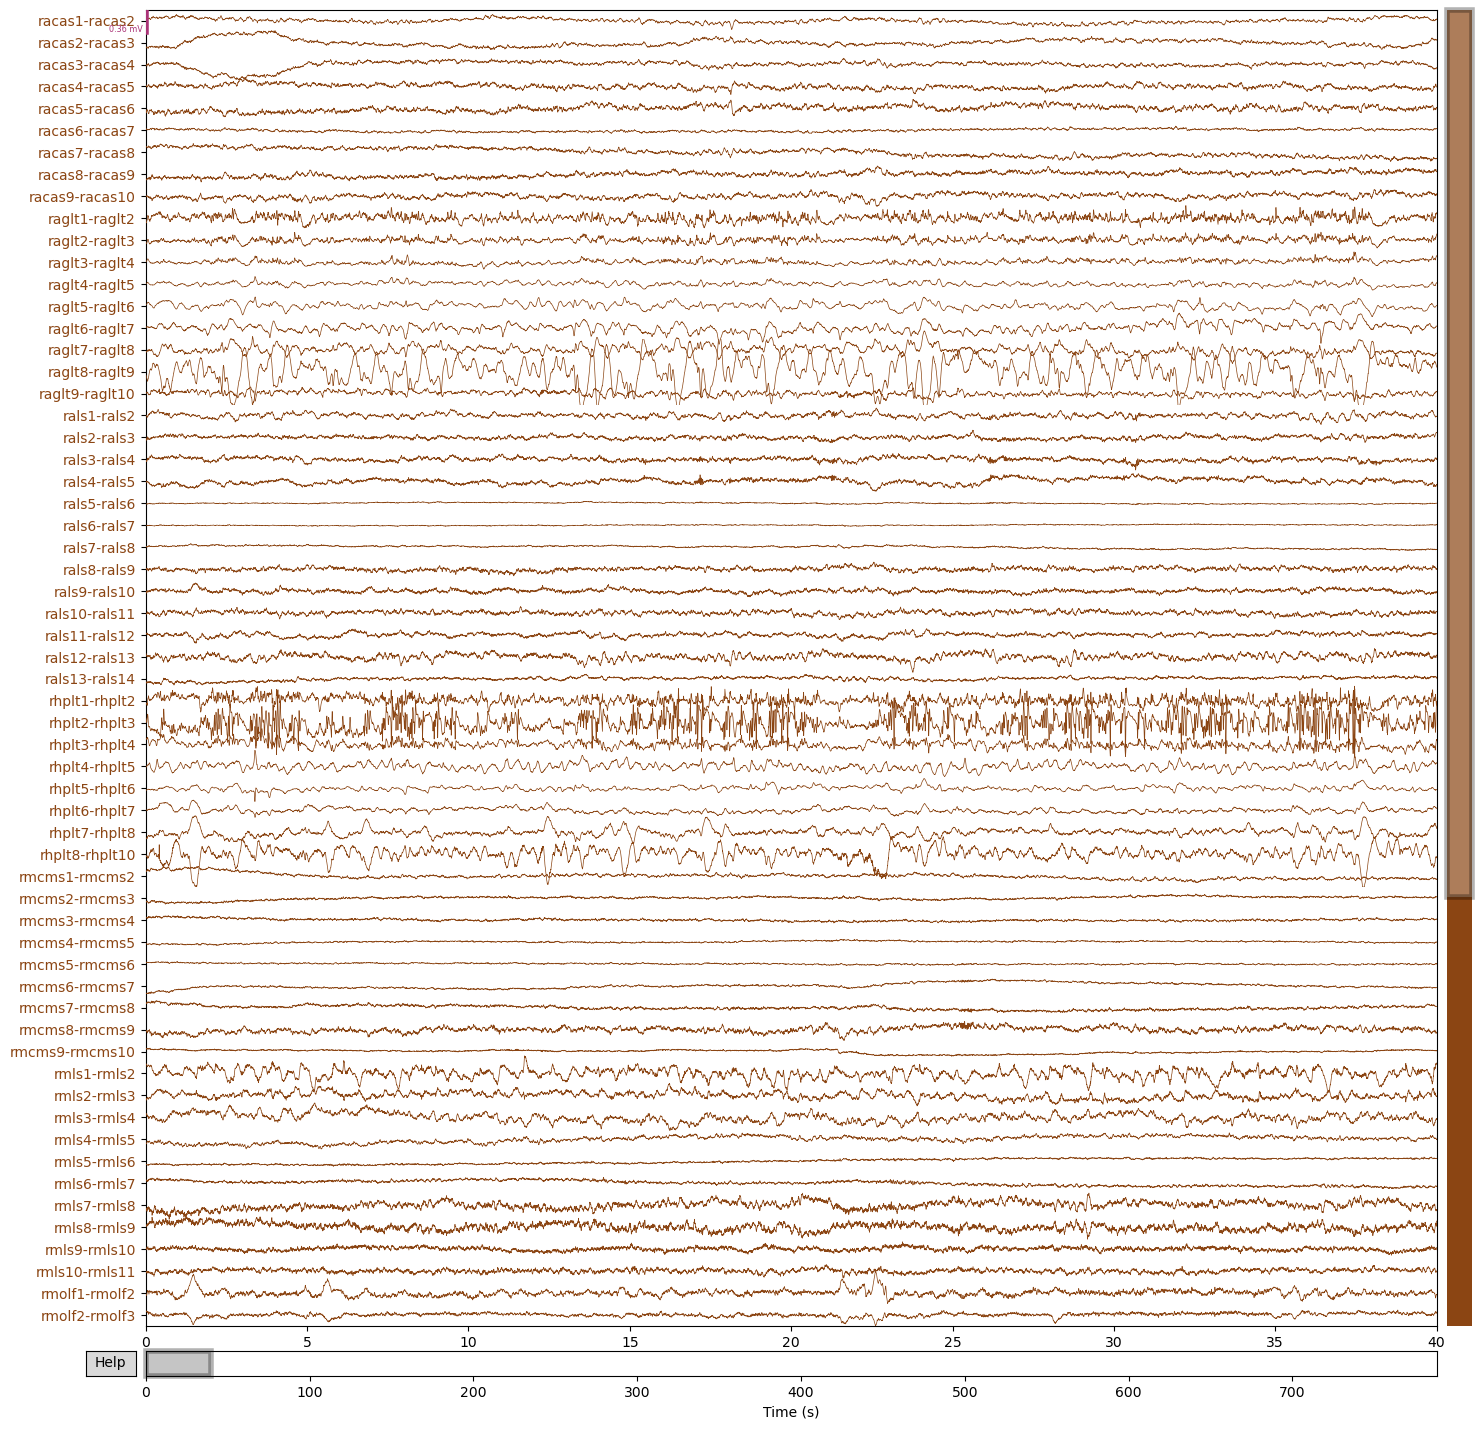

In [37]:
fig = mne_data_reref.plot(start=0, duration=40, n_channels=60, 
                      scalings=mne_data_reref._data.max()/5
                     )

 - mne_data: a Raw mne object, where the data has been loaded, filtered for line noise, searched for bad channels, parsed for different data types, and resampled if necessary. 
 
 - mne_data_reref: an mne object containing re-referenced data (either white matter or bipolar)

If you have ran the preprocessing above, load the data instead: 

In [36]:
%matplotlib inline

## Load neural data

In [30]:
# Through the first method: 
IED_sec_dict = lfp_preprocess_utils.detect_IEDs(mne_data_reref, peak_thresh=4, closeness_thresh=0.25, width_thresh=0.2)


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:    1.7s finished


In [15]:
elec_dict = {f'{x}': {f'{y}': [] for y in days} for x in subj_ids}
mne_dict = {f'{x}': {f'{y}': [] for y in days} for x in subj_ids}
photodiode_dict = {f'{x}': {f'{y}': [] for y in days} for x in subj_ids}

In [16]:
for ix, subj_id in enumerate(subj_ids): 
    for day in days:
        # Check if this day is in the dataset:
        if subj_df[day].values[ix] == 0:
            print (f'subject {subj_id} does not have Day 2 data')
            continue
        else:
            # Set paths
            load_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/neural/{day}'
            elec_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/anat/'
            save_path = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}/neural/{day}'

            elec_files = glob(f'{elec_path}/*.csv') + glob(f'{elec_path}/*.xlsx')
            # There should really only be one 
            elec_file = elec_files[0]
            elec_data = lfp_preprocess_utils.load_elec(elec_file)

            mne_data_reref = mne.io.read_raw_fif(f'{save_path}/bp_ref_ieeg.fif', preload=True)

            photodiode_data = mne.io.read_raw_fif(f'{load_path}/photodiode.fif', preload=True)

            # Append to list 
            mne_dict[subj_id][day].append(mne_data_reref)

            photodiode_dict[subj_id][day].append(photodiode_data)

            elec_dict[subj_id][day].append(elec_file)

/tmp/ipykernel_59966/166778422.py:20: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS012/neural/Day1/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  photodiode_data = mne.io.read_raw_fif(f'{load_path}/photodiode.fif', preload=True)


subject MS012 does not have Day 2 data


/tmp/ipykernel_59966/166778422.py:20: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS015/neural/Day1/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  photodiode_data = mne.io.read_raw_fif(f'{load_path}/photodiode.fif', preload=True)
/tmp/ipykernel_59966/166778422.py:20: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS015/neural/Day2/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  photodiode_data = mne.io.read_raw_fif(f'{load_path}/photodiode.fif', preload=True)
/tmp/ipykernel_59966/166778422.py:20: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salm

subject MS022 does not have Day 2 data


/tmp/ipykernel_59966/166778422.py:20: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS023/neural/Day1/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  photodiode_data = mne.io.read_raw_fif(f'{load_path}/photodiode.fif', preload=True)
/tmp/ipykernel_59966/166778422.py:20: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS023/neural/Day2/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  photodiode_data = mne.io.read_raw_fif(f'{load_path}/photodiode.fif', preload=True)
/tmp/ipykernel_59966/166778422.py:20: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salm

subject MS028 does not have Day 2 data


/tmp/ipykernel_59966/166778422.py:20: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS030/neural/Day1/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  photodiode_data = mne.io.read_raw_fif(f'{load_path}/photodiode.fif', preload=True)
/tmp/ipykernel_59966/166778422.py:20: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS030/neural/Day2/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  photodiode_data = mne.io.read_raw_fif(f'{load_path}/photodiode.fif', preload=True)
/tmp/ipykernel_59966/166778422.py:20: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salm

subject MS034 does not have Day 2 data


/tmp/ipykernel_59966/166778422.py:20: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS035/neural/Day1/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  photodiode_data = mne.io.read_raw_fif(f'{load_path}/photodiode.fif', preload=True)
/tmp/ipykernel_59966/166778422.py:20: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salman/EMU/MS035/neural/Day2/photodiode.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  photodiode_data = mne.io.read_raw_fif(f'{load_path}/photodiode.fif', preload=True)
/tmp/ipykernel_59966/166778422.py:20: RuntimeWarning: This filename (/sc/arion/projects/guLab/Salm


 - mne_dict: a dictionary containing all of your subjects' re-referenced mne data 
 
 - photodiode_dict: a dictionary containing all of your subjects' photodiode data 
 
 - elec_dict: a dictionary containing the paths to your subjects' electrode data 

## Sync behavioral and neural data



Here, we perform a critical step: computing the time offset between the computer that recorded the neural data and the laptop that featured the experiment. 

The function here only requires a **subset** of detected sync signals (i.e. photodiode deflections) to be detected to successfully compute this offset. 


First, some of the photodiode data can be a bit crummy, which you need to clean up in an idiosyncratic way... ugh

In [272]:
photodiode_dict[subj_id][day][0]

<Raw | photodiode.fif, 1 x 1408000 (1375.0 s), ~10.7 MB, data loaded>

In [266]:
subj_id = 'MS015'
day = 'Day1'
temp_diode = photodiode_dict[subj_id][day][0]._data[0, :]
temp_diode[900000:] = np.nanmin(temp_diode)
# photodiode_dict[subj_id][day][0]._data = temp_diode[0:420000]
# temp_diode[temp_diode>.13] = 0.1
photodiode_dict[subj_id][day][0]._data = temp_diode


In [115]:
subj_id = 'MS022'
day = 'Day1'
temp_diode = np.abs(photodiode_dict[subj_id][day][0]._data[0,:])
temp_diode[temp_diode>.13] = 0.1
photodiode_dict[subj_id][day][0]._data = temp_diode

subj_id = 'MS026'
day = 'Day1'
temp_diode = photodiode_dict[subj_id][day][0]._data[0,:]
temp_diode[temp_diode>4000] = 0
photodiode_dict[subj_id][day][0]._data = temp_diode

subj_id = 'MS028'
day = 'Day1'
temp_diode = photodiode_dict[subj_id][day][0]._data[0,:]
temp_diode[temp_diode>4000] = 0
temp_diode[temp_diode<-3000] = 0
photodiode_dict[subj_id][day][0]._data = temp_diode

subj_id = 'MS030'
day = 'Day1'
temp_diode = photodiode_dict[subj_id][day][0]._data[0,:]
temp_diode[temp_diode>0.005] = 0.005
temp_diode[temp_diode>-0.002] = 0.004
temp_diode[temp_diode<-0.004] = -0.004
photodiode_dict[subj_id][day][0]._data = temp_diode

subj_id = 'MS034'
day = 'Day1'
temp_diode = -(photodiode_dict[subj_id][day][0]._data[0,:])
temp_diode[temp_diode>-0.225] = -0.225
temp_diode[temp_diode>-0.2375] = -0.225
photodiode_dict[subj_id][day][0]._data = temp_diode

subj_id = 'MS035'
day = 'Day1'
temp_diode = -(photodiode_dict[subj_id][day][0]._data[0,:])
temp_diode[temp_diode>-0.25] = -0.25
photodiode_dict[subj_id][day][0]._data = temp_diode

subj_id = 'MS035'
day = 'Day2'
temp_diode = -(photodiode_dict[subj_id][day][0]._data[0,:])
temp_diode[temp_diode>-0.25] = -0.25
photodiode_dict[subj_id][day][0]._data = temp_diode

subj_id = 'MS036'
day = 'Day1'
temp_diode = -(photodiode_dict[subj_id][day][0]._data[0,:])
photodiode_dict[subj_id][day][0]._data = temp_diode


subj_id = 'MS036'
day = 'Day2'
temp_diode = -(photodiode_dict[subj_id][day][0]._data[0,:])
photodiode_dict[subj_id][day][0]._data = temp_diode

Now, let's compute the slopes and offsets

In [68]:
subj_ids

array(['MS012', 'MS015', 'MS016', 'MS017', 'MS019', 'MS020', 'MS022',
       'MS023', 'MS024', 'MS025', 'MS026', 'MS028', 'MS030', 'MS034',
       'MS035', 'MS036'], dtype=object)

In [267]:
slopes = {f'{x}': {f'{y}': [] for y in days} for x in subj_ids}
offsets = {f'{x}': {f'{y}': [] for y in days} for x in subj_ids}


for ix, subj_id in enumerate(subj_ids[1:2]): 
    for day in days:
        # Check if this day is in the dataset:
        if subj_df[1:2][day].values[ix] == 0:
            print (f'subject {subj_id} does not have Day 2 data')
            continue
        else:
            print(f'Working on subj {subj_id}')
            # Load the behavioral timestamps: 
            behav_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/behav/{day}'
            temp_df = pd.read_csv(glob(f'{behav_path}/*.csv')[0], index_col=None, header=0)
            # Load in the timestamps pertaining to your sync. If your task had a square pop up, for example, grab the times for that square's appearance from the behavioral logs.
            # Below, I do this for my own task's Psychopy output, but yours is probably coded differently. 
            beh_ts = temp_df[temp_df.keys()[temp_df.keys().str.startswith('sync') & temp_df.keys().str.endswith('started')]].values
            beh_ts = beh_ts[~np.isnan(beh_ts)] 

            # Synchronize to the photodiode or whatever your neural sync signal is
            height = 1
            windSize = 15
            smoothSize = 11
            if subj_id in ['MS015']:
                if day == 'Day1':
                    height = 1
                    windSize = 35
                    smoothSize = 10
            if subj_id in ['MS020']:
                if day == 'Day1':
                    height = 1.5
#             elif subj_id in ['MS022', 'MS025', 'MS026']:
#                 if day == 'Day1':
#                     height = 2
#             elif subj_id in ['MS028']:
#                 if day == 'Day1':
#                     height = 0.5            
            slope, offset = sync_utils.synchronize_data(beh_ts, 
                                                        photodiode_dict[subj_id][day][0], 
                                                        smoothSize=smoothSize, windSize=windSize, height=height)

            slopes[subj_id][day].append(slope)
            offsets[subj_id][day].append(offset)

Working on subj MS015
10 blocks
..........

found matches for 70 of 380 pulses
Working on subj MS015
10 blocks
..........

found matches for 150 of 160 pulses


In [268]:
offsets

{'MS012': {'Day1': [], 'Day2': []},
 'MS015': {'Day1': [-725.8561889462593], 'Day2': [-69.95994342856402]},
 'MS016': {'Day1': [], 'Day2': []},
 'MS017': {'Day1': [], 'Day2': []},
 'MS019': {'Day1': [], 'Day2': []},
 'MS020': {'Day1': [], 'Day2': []},
 'MS022': {'Day1': [], 'Day2': []},
 'MS023': {'Day1': [], 'Day2': []},
 'MS024': {'Day1': [], 'Day2': []},
 'MS025': {'Day1': [], 'Day2': []},
 'MS026': {'Day1': [], 'Day2': []},
 'MS028': {'Day1': [], 'Day2': []},
 'MS030': {'Day1': [], 'Day2': []},
 'MS034': {'Day1': [], 'Day2': []},
 'MS035': {'Day1': [], 'Day2': []},
 'MS036': {'Day1': [], 'Day2': []}}

In [275]:
(beh_ts[-1] - beh_ts[0]) / 60

23.082113606666585

In [109]:
# Save the sync info
file = f'{base_dir}/projects/guLab/Salman/EMU/slopes.json'
with open(file, 'wb') as f: 
    pickle.dump(slopes, f, pickle.HIGHEST_PROTOCOL)
    f.close()
file = f'{base_dir}/projects/guLab/Salman/EMU/offsets.json'
with open(file, 'wb') as f: 
    pickle.dump(offsets, f, pickle.HIGHEST_PROTOCOL)
    f.close()



 - slopes: a dictionary containing the slopes (should be ~ 1) for each subject
 - offsets: a dictionary containing the offsets for each subject

## Load the sync data

In [21]:
# Load the sync info
file = f'{base_dir}/projects/guLab/Salman/EMU/slopes.json'
with open(file, 'rb') as f: 
    slopes = pickle.load(f)
file = f'{base_dir}/projects/guLab/Salman/EMU/offsets.json'
with open(file, 'rb') as f: 
    offsets = pickle.load(f)


## Load your behavioral data

You probably have a separate notebook for processing the behavioral data for your task. Load the processed dataframe here:



In [44]:
behav_data = pd.read_csv(f'{base_dir}/work/qasims01/MemoryBanditData/EMU/learn_df.csv')

# Filter just to the participants in this notebook
behav_data = behav_data[behav_data.participant.isin(subj_ids)]

behav_data.head(5)[['participant', 'gamble_start', 'feedback_start', 'baseline_start']]

participant  gamble_start  feedback_start  baseline_start
0       MS012    234.674028      243.239158      244.929025
1       MS012    245.496340      248.344187      250.043187
2       MS012    251.043874      254.083059      255.790670
3       MS012    256.591595      258.148220      259.838892
4       MS012    260.439445      261.943712      263.620631

## Make epochs

Make epochs and remove IEDs. Currently just doing this for one example period - when subjects receive feedback.

In [46]:
# set some windows of interest 

buf = 1.0 # this is the buffer before and after that we use to limit edge effects for TFRs

IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

# evs = ['gamble_start', 'feedback_start', 'baseline_start']
evs = {'gamble_start': [-1.0, 0.5],
       'feedback_start': [-0.5, 1.5],
       'baseline_start': [0, 0.75]}


# add behavioral times of interest 
for subj_id in subj_ids:
    for day in ['Day1']: # , 'Day2'
        # Set paths
        load_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/neural/{day}'
        save_path = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}/neural/{day}'

        epochs_all_evs = {f'{x}': np.nan for x in evs}
        for event in evs.keys():
            pre = evs[event][0]
            post = evs[event][1]
            fixed_baseline = None
            behav_times = behav_data[(behav_data.participant==subj_id)][event]
#             baseline_times = combined_df[(combined_df.participant==subj_id) & (combined_df.condition==f'{day}')].dropna(subset='trials_gamble').baseline_start_mem

            epochs = lfp_preprocess_utils.make_epochs(load_path=f'{save_path}/bp_ref_ieeg.fif', 
                                                      slope=slopes[subj_id][day][0], offset=offsets[subj_id][day][0], 
                                                      behav_name=event, behav_times=behav_times,
                                                      ev_start_s=pre, ev_end_s=post, buf_s=1, downsamp_factor=None, IED_args=IED_args)

            
            epochs_all_evs[event] = epochs
            epochs_all_evs[event].save(f'{save_path}/{event}-epo.fif', overwrite=True)

        



[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 7120 out of 7120 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  89 out of  89 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend Sequent

ValueError: metadata must have the same number of rows (80) as events (79)

In [66]:
behav_data[(behav_data.participant=='MS019')][event]

480    130.630454
481    143.788433
482    154.033728
483    158.315133
484    165.595151
          ...    
555    676.730489
556    682.327995
557    686.526093
558    690.690832
559    695.138843
Name: gamble_start, Length: 80, dtype: float64

In [67]:
offsets[subj_id][day][0]

-725.8542487258169

In [60]:
[(x*slopes[subj_id][day][0] + offsets[subj_id][day][0]) for x in behav_times]

[-5.545031825052661,
 14.628207678216086,
 20.692310523896822,
 25.989855780792027,
 29.48984024957167,
 34.28614613287425,
 38.567585069898314,
 44.881412747605964,
 54.227224497791326,
 59.025026389085156,
 64.75576335659923,
 68.47075677222585,
 75.15127560585336,
 78.93308507787788,
 82.63123440366076,
 87.06251423992933,
 93.04317844054856,
 97.82473764520216,
 104.67151226561987,
 108.61947932391968,
 112.23459300678894,
 116.19938275482991,
 122.86309769881416,
 129.4101566205661,
 136.04050348657768,
 142.97072235208566,
 151.01709807113855,
 156.28138445063098,
 160.47969314424415,
 164.61132188218846,
 175.13949663904668,
 181.58671362825442,
 186.25494812843237,
 193.26487341909512,
 198.39583418743246,
 204.07689548998803,
 207.841757571617,
 213.8056433827487,
 218.18683895186734,
 222.23508384505226,
 225.76720698525742,
 230.44819675346173,
 235.97899865454076,
 244.92493477181404,
 248.58996422093185,
 252.80480370271835,
 256.7863765402643,
 263.8166900396824,
 268.214

In [49]:
subj_id

'MS015'

In [553]:
save_path

'/sc/arion/work/qasims01/MemoryBanditData/EMU/Subjects/MS020/neural/Day2'

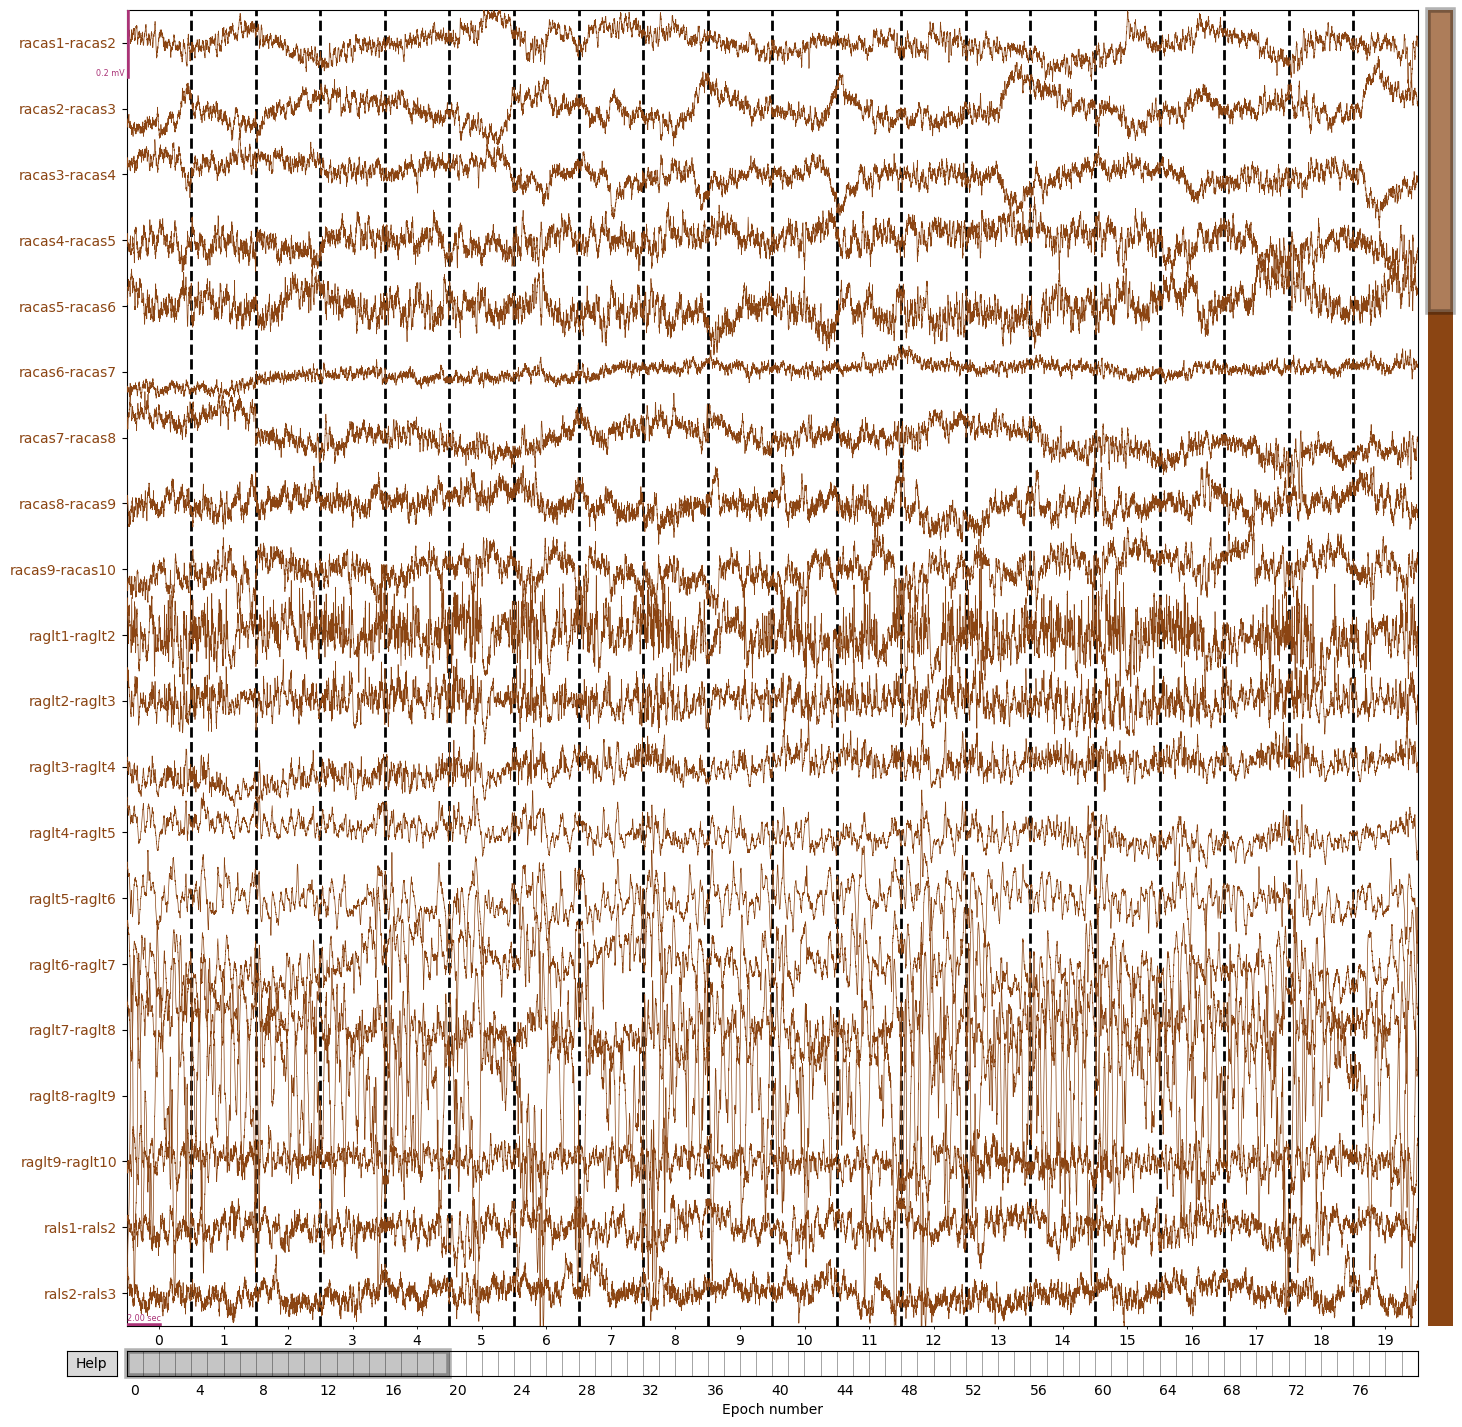

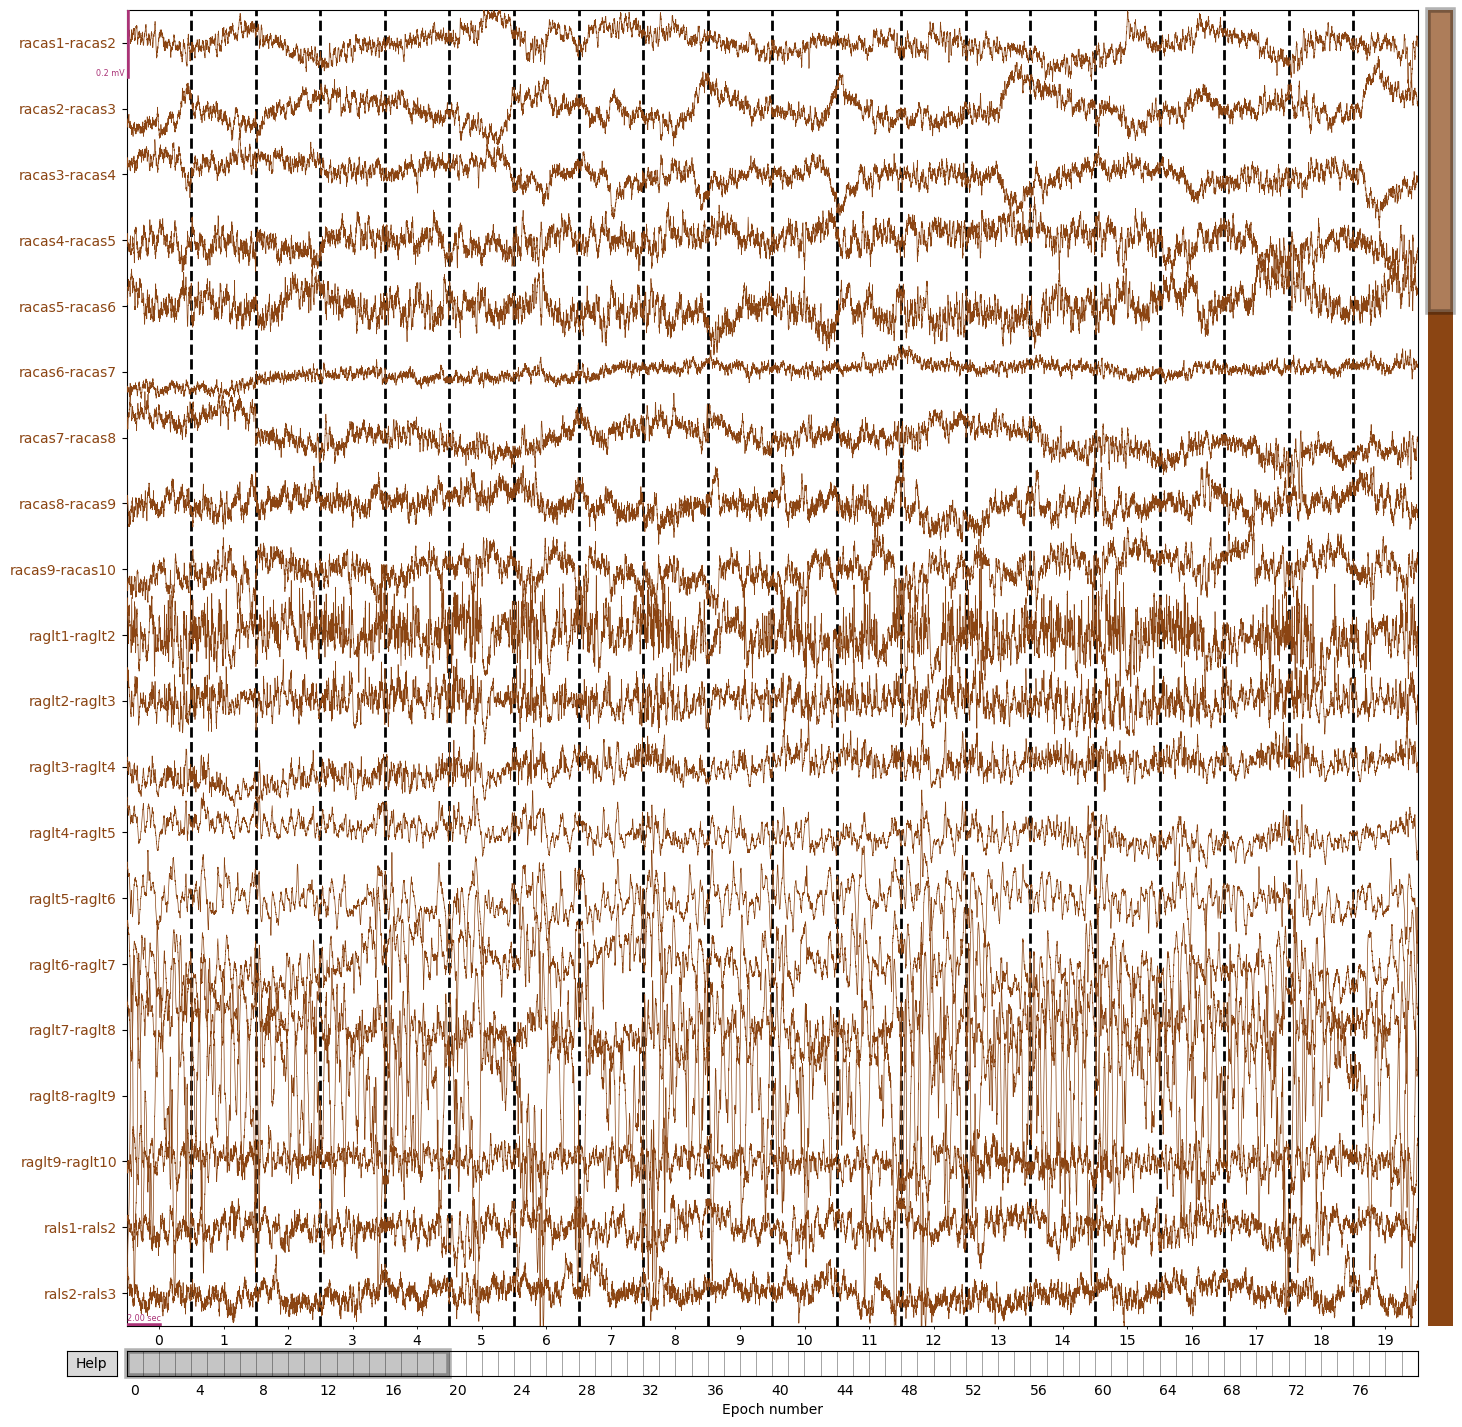

In [352]:
epochs.plot()

## Extract the relevant dataframes and plots for one subject before expanding to group analysis: 

We probably want to produce two dataframes: 

1. Electrode-level: This is the highest-level dataframe, which is computing electrode-level traits for all trials, which cannot be computed at the trial-level, as well as parsing by conditions. Should be mergeable with the next level.

2. Trial-level: This is the second-level dataframe, which is computing trial-level traits for each electrode. 

3. Timewise: This is the third-level dataframe, used sparingly. It will include timepoints for time-specific results. 

This involves running a series of analyses: 


0. Compute power spectrum 

1. FOOOF (all trials) 

2. FOOOF (conditions) 

3. TFR 

4. eBOSC 

5. catch-22 traits

6. ripple algorithm

7. temporally-resolved regression (optional - timewise)


Each analysis also has the potential to generate both data objects as well as plots that we might want to sve. We should make it optional as to whether all these exhaust fumes should actually be saved or not. 

In [38]:
electrode_level_data = pd.DataFrame(columns=['task', 'subject', 'channel', 'region', 'condition', 'frequency', 'PSD_raw', 'PSD_corrected', 'in_FOOOF_peak', 'PSD_exp', 'TFR']) 
trial_level_data = pd.DataFrame(columns=['task', 'subject', 'channel', 'region', 'condition', 'frequency', 'trial', 'TFR', 'BOSC', 'ripple_rate'])
         
timewise_data = pd.DataFrame(columns=['task', 'subject', 'channel', 'region', 'condition', 'frequency', 'trial', 'time'])
    

In [39]:
# Load one person's data 
subj_id = 'MS012'
day = 'Day1'
save_path = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}/neural/{day}'

In [40]:
mne_data_reref = mne.read_epochs(f'{save_path}/feedback_start-epo.fif', preload=True)

In [ ]:
evs = {'gamble_start': [-1.0, 0.5],
       'feedback_start': [-0.5, 1.5],
       'baseline_start': [0, 0.75]}

In [50]:
# Put in the behavioral data for the different tasks

evs_for_dm_only = behav_data[(behav_data.participant==subj_id)]

evs_for_dm_and_mem = combined_df[(combined_df.participant==subj_id)].sort_values(by=['trials_gamble']).dropna(subset=['trials_gamble']).reset_index(drop=True)

mne_data_reref.metadata = evs_for_dm_only



## Power spectrum (FOOOF)

Here, we are going to plot the group-level FOOOF analysis for two conditions in the task across all channels, and then also plot the individual power spectrums for each channel with model fit for each of the two conditions. Note the time specification to make sure I leave out the baseline period... 

FOOOF's primary utility, imo, is not in peak parameterization but 1/f subtraction. Peak parameters are subject to over- and under-fitting, and fit quality has too strong of an effect. Simply contrasting *n* PSDs (for *n* conditions) after removing the 1/f is a more healthy approach imo.

For guidance on picking the parameters used to fit: https://fooof-tools.github.io/fooof/auto_tutorials/plot_07-TroubleShooting.html#sphx-glr-auto-tutorials-plot-07-troubleshooting-py

In [18]:
# Import plotting functions
from fooof.plts.spectra import plot_spectrum, plot_spectra

# Import the FOOOF object
from fooof import FOOOF


## 1. FOOOF (produce dataframe and condition-specific plots)

In [ ]:
ev_dict = {'feedback_start': [0, 1.5]}

# Define peak_width, peak_height, peak_threshold, max_n_peaks
FOOOF_kwargs = {'peak_width_limits': [1, 8], 
               'min_peak_height': 0.1,
                'peak_threshold': 1.,
                'max_n_peaks': 3,
               'freq_range': [1, 30]}
 
# Define our frequency bands of interest
band_dict = {'delta' : [1, 4],
               'theta' : [4, 8],
               'alpha' : [8, 13],
               'beta' : [13, 30]}

conditions = ['reward==0',
             'reward==1']


# For now, let's go channel-by-channel, otherwise I would define our ROIs as such:
# rois = ['hippocampus']
## , 'amygdala', 'insula', 'frontal', 'parahippocampal'
## , 'entorhinal', 'anterior_cingulate'

for subj_id in ['MS012']:
    save_path = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}'
    # Get electrode df 
    elec_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/anat/'
    # electrode files could either be csv or excel
    elec_files = glob(f'{elec_path}/*.csv') + glob(f'{elec_path}/*.xlsx')
    # There should really only be one 
    elec_file = elec_files[0]
    
#     # IF Picking ROI: Revise labelling in electrode csv in order to match the re-referenced channel names 
#     elec_data = lfp_preprocess_utils.load_elec(elec_file)
#     anode_list = [x.split('-')[0] for x in mne_data_reref[list(evs.keys())[0]].ch_names]
#     elec_df = elec_data[elec_data.label.str.lower().isin(anode_list)]
#     elec_df['label'] =  elec_df.label.apply(lambda x: [a for a in mne_data_reref.ch_names if str(x).lower() in a.split('-')[0]][0])
        
    progress_bar = tqdm(mne_data_reref.ch_names, ascii=True, desc='Computing FOOOF')
    
    for chan in progress_bar: 
        dfs = [] 
        for event in ev_dict.keys():   
            filepath = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}/scratch/FOOOF/{event}'
            if not os.path.exists(f'{filepath}/plots'):
                os.makedirs(f'{filepath}/plots')
            if not os.path.exists(f'{filepath}/dfs'):
                os.makedirs(f'{filepath}/dfs')
                
            # Can pick the epoch depending on the event being selected
            chan_epochs = mne_data_reref.copy().pick_channels([chan])

            # FOOOF across all trials: 
            FOOOFGroup_res, df_all = analysis_utils.FOOOF_compute_epochs(chan_epochs, tmin=evs[event][0], tmax=evs[event][1], 
                                                                band_dict=band_dict, **FOOOF_kwargs)

            df_all['cond'] = 'all'
            df_all['event'] = event
            
            # TODO: add regions (11/15/23)

            dfs.append(df_all)

            df_conds = []
            for cond in conditions: 
                chan_epochs = mne_data_reref[cond].copy().pick_channels([chan])

                FOOOFGroup_res, df_temp = analysis_utils.FOOOF_compute_epochs(chan_epochs, tmin=evs[event][0], tmax=evs[event][1], 
                                                                band_dict=band_dict, **FOOOF_kwargs)


                df_temp['cond'] = cond
                df_temp['event'] = event
                
                # TODO: add regions (11/15/23)

                df_conds.append(df_temp)

            df_conds = pd.concat(df_conds)
            dfs.append(df_conds)

            chan_df = pd.concat(dfs)
            chan_df.insert(0,'subj', subj_id)
            
            fig = sns.lineplot(data=chan_df, x='frequency', y='PSD_corrected', hue='cond')
            figure = fig.get_figure()    
            figure.savefig(f'{filepath}/plots/{chan}_FOOOF.pdf', dpi=100)
            plt.close()
            # save this chan_df out 
            
            chan_df.to_csv(f'{filepath}/dfs/{chan}_df.csv', index=False)
    

The above takes about 2 seconds per channel - not bad.

In [27]:
# Load the dataframes: 
chan_dfs = [] 
for chan in tqdm(mne_data_reref.ch_names, ascii=True, desc='Loading FOOOF dataframes'): 
    chan_df = pd.read_csv(f'{filepath}/dfs/{chan}_df.csv')
    chan_dfs.append(chan_df)
chan_dfs = pd.concat(chan_dfs)

Loading FOOOF dataframes: 100%|##########| 89/89 [00:01<00:00, 71.74it/s]


In [45]:
chan_df.frequency.unique()

array([ 1.33155792,  1.99733688,  2.66311585,  3.32889481,  3.99467377,
        4.66045273,  5.32623169,  5.99201065,  6.65778961,  7.32356858,
        7.98934754,  8.6551265 ,  9.32090546,  9.98668442, 10.65246338,
       11.31824234, 11.9840213 , 12.64980027, 13.31557923, 13.98135819,
       14.64713715, 15.31291611, 15.97869507, 16.64447403, 17.310253  ,
       17.97603196, 18.64181092, 19.30758988, 19.97336884, 20.6391478 ,
       21.30492676, 21.97070573, 22.63648469, 23.30226365, 23.96804261,
       24.63382157, 25.29960053, 25.96537949, 26.63115846, 27.29693742,
       27.96271638, 28.62849534, 29.2942743 , 29.96005326])

In [30]:
chan_dfs[chan_dfs.channel]

subj          channel  frequency   PSD_raw  PSD_corrected  \
0    MS012    racas1-racas2   1.331558 -7.291907      -0.151886   
1    MS012    racas1-racas2   1.997337 -7.395764       0.078146   
2    MS012    racas1-racas2   2.663116 -7.436460       0.274349   
3    MS012    racas1-racas2   3.328895 -7.669541       0.225021   
4    MS012    racas1-racas2   3.994674 -7.742878       0.301821   
..     ...              ...        ...       ...            ...   
127  MS012  rpls115-rpls116  27.296937 -8.870057      -0.035991   
128  MS012  rpls115-rpls116  27.962716 -8.886825      -0.031169   
129  MS012  rpls115-rpls116  28.628495 -8.910513      -0.033776   
130  MS012  rpls115-rpls116  29.294274 -8.926275      -0.028942   
131  MS012  rpls115-rpls116  29.960053 -8.939293      -0.021826   

     in_FOOOF_peak  peak_freq  peak_height   PSD_exp       cond  \
0              0.0   0.000000     0.000000  1.896118        all   
1              0.0   0.000000     0.000000  1.896118        all   
2              0.0   0.000000     0.000000  1.896118        all   
3              0.0   0.000000     0.000000  1.896118        all   
4              1.0   5.856034     0.373176  1.896118        all   
..             ...        ...          ...       ...        ...   
127            0.0   0.000000     0.000000  2.062906  reward==1   
128            0.0   0.000000     0.000000  2.062906  reward==1   
129            0.0   0.000000     0.000000  2.062906  reward==1   
130            0.0   0.000000     0.000000  2.062906  reward==1   
131            0.0   0.000000     0.000000  2.062906  reward==1   

              event  
0    feedback_start  
1    feedback_start  
2    feedback_start  
3    feedback_start  
4    feedback_start  
..              ...  
127  feedback_start  
128  feedback_start  
129  feedback_start  
130  feedback_start  
131  feedback_start  

[11748 rows x 11 columns]

<AxesSubplot:xlabel='frequency', ylabel='PSD_corrected'>

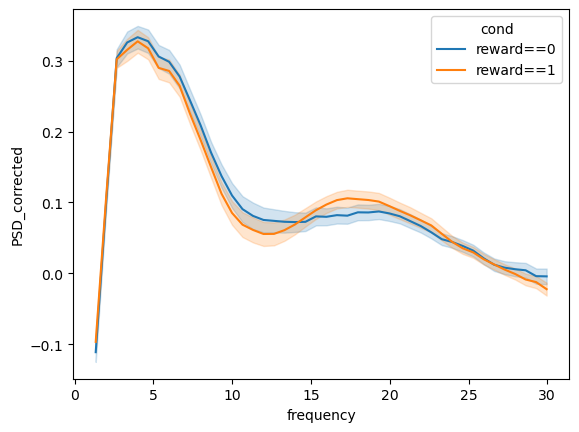

In [29]:
sns.lineplot(data=chan_dfs[chan_dfs.cond!='all'], x='frequency', y='PSD_corrected', hue='cond', errorbar='se')

In [41]:
grouped_df = chan_dfs.groupby(['channel', 'cond', 'in_FOOOF_peak']).mean().reset_index().drop(columns=['in_FOOOF_peak', 'frequency', 'PSD_raw'])


                                                                                 
                                                                                 

/tmp/ipykernel_156333/1422459577.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = chan_dfs.groupby(['channel', 'cond', 'in_FOOOF_peak']).mean().reset_index().drop(columns=['in_FOOOF_peak', 'frequency', 'PSD_raw'])


In [42]:
grouped_df[grouped_df.peak_freq!=0]

channel       cond  PSD_corrected  peak_freq  peak_height  \
1     racas1-racas2        all       0.326492   5.856034     0.373176   
2     racas1-racas2        all       0.130392  16.092339     0.139405   
4     racas1-racas2  reward==0       0.358800   6.229078     0.393545   
5     racas1-racas2  reward==0       0.119100  16.290789     0.125160   
7     racas1-racas2  reward==1       0.286600   3.787796     0.310482   
..              ...        ...            ...        ...          ...   
881   rpls18-rpls19  reward==1       0.314957   5.830980     0.364055   
883  rpls19-rpls110        all       0.268275   6.874738     0.302765   
885  rpls19-rpls110  reward==0       0.276556   7.297774     0.310845   
887  rpls19-rpls110  reward==1       0.308661   5.977401     0.341569   
888  rpls19-rpls110  reward==1       0.110483  15.831116     0.122501   

      PSD_exp  
1    1.896118  
2    1.896118  
4    1.967804  
5    1.967804  
7    1.887392  
..        ...  
881  1.217602  
883  1.508302  
885  1.581329  
887  1.526115  
888  1.526115  

[622 rows x 6 columns]

In [153]:
# # Fit an individual channel (for plotting)
# ind_fits = FOOOFGroup_res.get_fooof(ind=0, regenerate=True)
# ind_fits.fit()

In [154]:
# ind_fits.plot()

# eBOSC

After epoching, we can compute the eBOSC, using the same frequency range we used for FOOOF. This is because both use line-fitting regiments for the PSD that tend to break down when higher frequencies are included. 

In [52]:
chan_df.frequency.unique().shape

(44,)

In [53]:
np.linspace(1,30, 44)

array([ 1.        ,  1.6744186 ,  2.34883721,  3.02325581,  3.69767442,
        4.37209302,  5.04651163,  5.72093023,  6.39534884,  7.06976744,
        7.74418605,  8.41860465,  9.09302326,  9.76744186, 10.44186047,
       11.11627907, 11.79069767, 12.46511628, 13.13953488, 13.81395349,
       14.48837209, 15.1627907 , 15.8372093 , 16.51162791, 17.18604651,
       17.86046512, 18.53488372, 19.20930233, 19.88372093, 20.55813953,
       21.23255814, 21.90697674, 22.58139535, 23.25581395, 23.93023256,
       24.60465116, 25.27906977, 25.95348837, 26.62790698, 27.30232558,
       27.97674419, 28.65116279, 29.3255814 , 30.        ])

In [51]:
cfg_eBOSC = dict()
cfg_eBOSC['F'] = np.linspace(1,30, 44)   # frequency sampling
cfg_eBOSC['wavenumber'] = 6                   # wavelet parameter (time-frequency tradeoff)
cfg_eBOSC['fsample'] = mne_data_reref.info['sfreq'] # current sampling frequency of EEG data
cfg_eBOSC['pad.tfr_s'] = 0                   #  padding following wavelet transform to avoid edge artifacts in seconds (bi-lateral)
cfg_eBOSC['pad.detection_s'] = 0             # padding following rhythm detection in seconds (bi-lateral); 'shoulder' for BOSC eBOSC.detected matrix to account for duration threshold
cfg_eBOSC['pad.background_s'] = 0             # padding of segments for BG (only avoiding edge artifacts)

cfg_eBOSC['threshold.excludePeak'] = np.array([])   # lower and upper bound of frequencies to be excluded during background fit (Hz) (previously: LowFreqExcludeBG HighFreqExcludeBG)
cfg_eBOSC['threshold.duration'] = np.kron(np.ones((1,len(cfg_eBOSC['F']))),3) # vector of duration thresholds at each frequency (previously: ncyc)
cfg_eBOSC['threshold.percentile'] = .95    # percentile of background fit for power threshold

cfg_eBOSC['postproc.use'] = 'no'           # Post-processing of rhythmic eBOSC.episodes, i.e., wavelet 'deconvolution' (default = 'no')
cfg_eBOSC['postproc.method'] = 'FWHM'       # Deconvolution method (default = 'MaxBias', FWHM: 'FWHM')
cfg_eBOSC['postproc.edgeOnly'] = 'yes'      # Deconvolution only at on- and offsets of eBOSC.episodes? (default = 'yes')
cfg_eBOSC['postproc.effSignal'] = 'PT'      # Power deconvolution on whole signal or signal above power threshold

cfg_eBOSC['trial'] = []            # select trials (default: all, indicate in natural trial number (not zero-starting))
cfg_eBOSC['trial_background'] = []       # select trials for background (default: all, indicate in natural trial

In [57]:
ev_dict = {'feedback_start': [0, 1.5]}

# Define peak_width, peak_height, peak_threshold, max_n_peaks
FOOOF_kwargs = {'peak_width_limits': [1, 8], 
               'min_peak_height': 0.1,
                'peak_threshold': 1.,
                'max_n_peaks': 3,
               'freq_range': [1, 30]}
 
# Define our frequency bands of interest
band_dict = {'delta' : [1, 4],
               'theta' : [4, 8],
               'alpha' : [8, 13],
               'beta' : [13, 30]}

conditions = ['reward==0',
             'reward==1']


# For now, let's go channel-by-channel, otherwise I would define our ROIs as such:
# rois = ['hippocampus']
## , 'amygdala', 'insula', 'frontal', 'parahippocampal'
## , 'entorhinal', 'anterior_cingulate'

for subj_id in ['MS012']:
    save_path = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}'
    # Get electrode df 
    elec_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/anat/'
    # electrode files could either be csv or excel
    elec_files = glob(f'{elec_path}/*.csv') + glob(f'{elec_path}/*.xlsx')
    # There should really only be one 
    elec_file = elec_files[0]
    
    progress_bar = tqdm(mne_data_reref.ch_names, ascii=True, desc='Computing eBOSC')
    
    for chan in progress_bar:
        display(progress_bar)
        cfg_eBOSC['channel'] = [chan]  
        for event in ev_dict.keys():   
            filepath = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}/scratch/eBOSC/{event}'
            if not os.path.exists(f'{filepath}/plots'):
                os.makedirs(f'{filepath}/plots')
            if not os.path.exists(f'{filepath}/dfs'):
                os.makedirs(f'{filepath}/dfs')

            # Can pick the epoch depending on the event being selected
            test_df = mne_data_reref.copy().pick_channels([chan]).to_data_frame(time_format=None)

            # Compute BOSC: 
            [eBOSC, cfg] = oscillation_utils.eBOSC_wrapper(cfg_eBOSC, test_df)

            # Cut off buffer time
            eBOSC['detected'] = eBOSC['detected'].query('(time>=0) & (time<=1.5)')

            eBOSC['detected'] = eBOSC['detected'].reset_index().rename(columns={0:'prop_detect'})

            # Add events to the BOSC data: 
            evs = mne_data_reref.metadata.copy()
            evs['trial'] = eBOSC['detected']['trial'].unique()
            eBOSC['detected'] = eBOSC['detected'].merge(evs, on=['trial'])

            # Dataframe for saving
            BOSC_save_df = pd.DataFrame(eBOSC['detected'].groupby(['trial', 'frequency']).mean()).reset_index().drop(columns=['time'])
            BOSC_save_df.insert(0,'channel', chan)
            BOSC_save_df.insert(0,'subj', subj_id)
            BOSC_save_df['event'] = event
            
            BOSC_save_df.to_csv(f'{filepath}/dfs/{chan}_df.csv', index=False)

            
            # If we want to plot
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[6,3], sharex=True, sharey=True)
            for ix, cond in enumerate(conditions): 
                # Plot: 
                detected_avg = pd.DataFrame(eBOSC['detected'].query(cond).groupby(['frequency', 'time']).mean().drop(columns=['trial'])['prop_detect'])

                # eBOSC['detected'].groupby(level=['frequency', 'time']).mean()
                detected_avg = detected_avg.pivot_table(index=['frequency'], columns='time')
                cur_multiindex = eBOSC['detected'].index
                cur_time = eBOSC['detected'].time.unique()
                # cur_multiindex.get_level_values('time').unique()
                cur_freq = eBOSC['detected'].frequency.unique()
                # cur_multiindex.get_level_values('frequency').unique()

                
#                 ax.vlines(250, 0, len(cfg_eBOSC['F']), 'white')
                im = ax[ix].imshow(detected_avg, aspect = 'auto', interpolation='bicubic', cmap='rocket', vmin=0, vmax=.4)

                [x0, x1] = ax[ix].get_xlim()
                [y0, y1] = ax[ix].get_ylim()
                xticks_loc = np.linspace(0,750, 4)
                # [t for t in ax.get_xticks() if t>=x0 and t<=x1]
                yticks_loc = [t for t in ax[ix].get_yticks() if t>=y1 and t<=y0]
                x_label_list = np.round(cur_time[np.int_(xticks_loc)],1).tolist()
                y_label_list = np.round(cur_freq[np.int_(yticks_loc)],1).tolist()
                ax[ix].set_xticks(xticks_loc)
                ax[ix].set_xticklabels(x_label_list)
                ax[ix].set_yticks(yticks_loc)
                ax[ix].set_yticklabels(y_label_list)
                ax[ix].invert_yaxis()
                ax[ix].set_xlabel('Time [s]')
                ax[ix].set_ylabel('Frequency [Hz]') 
                ax[ix].set_title(f'{cond}')
                fig.colorbar(im, ax=ax[ix])
            plt.suptitle('Avg. detected rhythms across trials', fontsize=12)
#             plt.show()
            plt.tight_layout()
            plt.savefig(f'{filepath}/plots/{chan}_eBOSC.pdf', dpi=100)
            plt.close()
            clear_output(wait = True)


Computing eBOSC: 100%|##########| 89/89 [1:10:42<00:00, 47.67s/it]


The above takes about 30-50 seconds per channel. So much slower but still not bad. 

In [80]:
# Load the dataframes: 
chan_dfs = [] 
for chan in tqdm(mne_data_reref.ch_names, ascii=True, desc='Loading eBOSC dataframes'): 
    chan_df = pd.read_csv(f'{filepath}/dfs/{chan}_df.csv')
    chan_dfs.append(chan_df)
chan_dfs = pd.concat(chan_dfs)

Loading eBOSC dataframes: 100%|##########| 89/89 [00:02<00:00, 33.07it/s]


<AxesSubplot:xlabel='frequency', ylabel='prop_detect'>

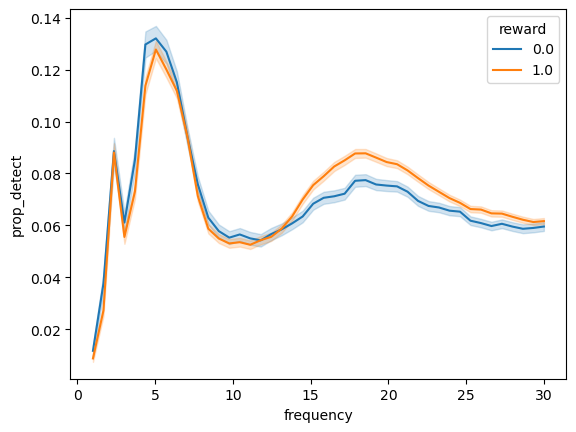

In [81]:
sns.lineplot(data=chan_dfs, x='frequency', y='prop_detect', hue='reward', errorbar='se')

## Wavelet TFRs

Here, we will plot some basic TFRs of our behaviorally-locked analysis using a wavelet transform. We can also use these to compute the inter-trial phase coherence (ITC). 

Let's set some parameters first


In [16]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict
analysis_evs = ['feedback_start']
baseline_ev = 'baseline_start'
evs = {'feedback_start': [0, 1.5],
       'baseline_start': [0, 0.75]}
for i in analysis_evs: 
    if i not in evs.keys(): 
        raise ValueError('This analysis event is not in the dictionary')

In [17]:
# Load one person's data 
subj_id = 'MS012'
day = 'Day1'
save_path = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}/neural/{day}'

In [18]:
feedback_epochs_reref = mne.read_epochs(f'{save_path}/feedback_start-epo.fif', preload=True)
baseline_epochs_reref = mne.read_epochs(f'{save_path}/baseline_start-epo.fif', preload=True)

In [22]:
# Merge in the behavioral data for the different tasks

evs_for_dm_only = behav_data[(behav_data.participant==subj_id)]

evs_for_dm_and_mem = combined_df[(combined_df.participant==subj_id)].sort_values(by=['trials_gamble']).dropna(subset=['trials_gamble']).reset_index(drop=True)


ied_data = feedback_epochs_reref.metadata.copy()
event_metadata = pd.concat([evs_for_dm_only, ied_data], axis=1)
feedback_epochs_reref.metadata = event_metadata

ied_data = baseline_epochs_reref.metadata.copy()
event_metadata = pd.concat([evs_for_dm_only, ied_data], axis=1)
baseline_epochs_reref.metadata = event_metadata



In [23]:
# Set some spectrogram parameters 
freqs = np.logspace(*np.log10([4, 120]), num=30)
n_cycles = 4  
sr = feedback_epochs_reref.info['sfreq']
# sr = epochs_all_subjs_all_evs[subj_id][baseline_ev].info['sfreq']
buf = 1.0
buf_ix = int(buf*sr)


baseline_power_epochs = {f'{a}': {f'{b}': np.nan for b in evs.keys()} for a in subj_ids}

power_epochs = {f'{a}': {f'{b}': np.nan for b in evs.keys()} for a in subj_ids}

First, compute the baseline power:

In [24]:
subj_ids

array(['MS012', 'MS015', 'MS016', 'MS017', 'MS019', 'MS020', 'MS022',
       'MS023', 'MS024', 'MS025', 'MS026', 'MS028', 'MS030', 'MS034',
       'MS035', 'MS036'], dtype=object)

In [25]:
# Compute baseline_power
for subj_id in ['MS012']:
    event = 'baseline_start'
    epochs = baseline_epochs_reref
    #epochs_all_subjs_all_evs[subj_id][event]
        
    # Let's make sure we only do this for good channels
    good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
    picks = [x for x in good_chans]

    pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                           epochs._data.shape[1], len(freqs), 
                           epochs._data.shape[-1]])

    progress_bar = tqdm(np.arange(epochs._data.shape[1]), ascii=True, desc='Computing TFR')
    
    for ch_ix in progress_bar: 
        ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
        bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0]
        good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
        ch_data = np.delete(ch_data, bad_epochs, axis=0)
        ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                             freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                            use_fft=True, output='power', n_jobs=1)

        pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]

    temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                            epochs.times, freqs)
    temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])

    baseline_power_epochs[subj_id][event] = temp_pow

Computing TFR: 100%|##########| 89/89 [01:24<00:00,  1.06it/s]


 - baseline_power_epochs: a dictionary containing all of your subjects' baseline TFR, with the buffer cropped out

Next, compute the power for the analysis events and BASELINE it using the baseline epochs: 

Use the metadata to assign conditions to parse your epochs!

In [26]:
evs = {'feedback_start': [0, 1.5],
       'baseline_start': [0, 0.75]}

In [33]:
for subj_id in ['MS012']:
    filepath = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}/scratch/TFR'
    if not os.path.exists(filepath):
        os.makedirs(filepath)
    for event in analysis_evs:
        
        epochs = feedback_epochs_reref
        ch_names = epochs.ch_names
        #epochs_all_subjs_all_evs[subj_id][event]
            
        # Let's make sure we only do this for good channels
        good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
        picks = [x for x in good_chans]
        
        pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                               epochs._data.shape[1], len(freqs), 
                               epochs._data.shape[-1]])
    
        progress_bar = tqdm(np.arange(epochs._data.shape[1]), ascii=True, desc='Baselining TFR')

        for ch_ix in progress_bar: 
            ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
            bad_epochs  = np.where(epochs.metadata[epochs.ch_names[ch_ix]].notnull())[0]
            good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
            ch_data = np.delete(ch_data, bad_epochs, axis=0)
            ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                                freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                                use_fft=True, output='power', n_jobs=1)

            pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]
        
        temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                                epochs.times, freqs)
        
        temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])
        
        # Baseline by all the baseline periods in the session
        baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                                                          baseline_mne=baseline_power_epochs[subj_id]['baseline_start'], 
                                                          mode='zscore', 
                                                          trialwise=False, 
                                                          baseline_only=True)
        # Baseline by trial, but combine baseline and epoch
#                                     lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
#                                                           baseline_mne=baseline_power_epochs[subj_id]['baseline_start'], 
#                                                           mode='zscore', 
#                                                           trialwise=True, 
#                                                           baseline_only=False)

        # baseline_corrected_power = lfp_preprocess_utils.zscore_TFR_across_trials(temp_pow.data, 
        #                               baseline_power_epochs[subj_id]['baseline_start'], mode='zscore', baseline_only=False)
        
        zpow = mne.time_frequency.EpochsTFR(epochs.info, baseline_corrected_power, 
                                        temp_pow.times, freqs)
        
        zpow.metadata = feedback_epochs_reref.metadata
        
        power_epochs[subj_id][event] = zpow
        
        # Save out the baselined TFR epochs:
        power_epochs[subj_id][event].save(f'{filepath}/{event}-tfr.h5', overwrite=True)

        

Baselining TFR: 100%|##########| 89/89 [00:45<00:00,  1.98it/s]


 - power_epochs: a dictionary containing all of your subjects' event TFR, with the buffer cropped out and NORMALIZED with the baseline + event period 

Now, let's compute the average spectrogram over some particular region: hippocampus, in this example

In [37]:
filepath = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}/scratch/TFR/{event}'
if not os.path.exists(f'{filepath}/plots'):
    os.makedirs(f'{filepath}/plots')
if not os.path.exists(f'{filepath}/dfs'):
    os.makedirs(f'{filepath}/dfs')

In [29]:
# # rois = ['hippocampus', 'amygdala', 'insula', 'cingulate' ,'frontal']
# region = 'hippocampus'

# band definitions for y-axis
yticks = [4, 8, 13, 30, 60, 120]

# task condition to contrast 
conditions = ['reward==0',
             'reward==1']


for subj_id in subj_ids:
    save_path = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}'
    # Get electrode df 
    elec_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/anat/'
    # electrode files could either be csv or excel
    elec_files = glob(f'{elec_path}/*.csv') + glob(f'{elec_path}/*.xlsx')
    # There should really only be one 
    elec_file = elec_files[0]
#     elec_data = lfp_preprocess_utils.load_elec(elec_file)

#     anode_list = [x.split('-')[0] for x in epochs_all_subjs_all_evs[subj_id][event].ch_names]
#     elec_df = elec_data[elec_data.label.str.lower().isin(anode_list)]
#     # Shawn noticed the following would incorrectly label electrodes if they're not in the same order as .ch_names! 
#     # elec_df['label'] = epochs_all_subjs_all_evs[subj_id][event].ch_names
#     # Fix: 
#     elec_df['label'] = elec_df['label'].apply(lambda x: next((string for string in epochs_all_subjs_all_evs[subj_id][event].ch_names if x in string), np.nan))
    

#     picks = analysis_utils.select_picks_rois(elec_df, region)
    progress_bar = tqdm(power_epochs[subj_id][event].ch_names, ascii=True, desc='Plotting TFR')

    for chan in progress_bar:
        for event in analysis_evs:
            fig, ax = plt.subplots(1, 2, figsize=(20, 6), dpi=300)
            for ix, cond in enumerate(conditions):
                # Set the times for 
                times = power_epochs[subj_id][event].times
                plot_data = np.nanmean(np.nanmean(power_epochs[subj_id][event][cond].copy().pick_channels([chan]).data, axis=0), axis=0)

                im = ax[ix].imshow(plot_data,
                          extent=[times[0], times[-1], freqs[0], freqs[-1]], interpolation='Bicubic',
                          aspect='auto', origin='lower', cmap='RdBu_r', vmin =-1, vmax = 1)
                ax[ix].set(yticks=yticks, xlabel='Time (s)', ylabel='Frequency', title=f'{subj_id}_{chan}_{cond}_{event}')
                fig.colorbar(im, ax=ax[ix])
                
        
            plt.savefig(f'{filepath}/plots/{chan}_TFR.pdf', dpi=100)
            plt.close()



Plotting TFR: 100%|##########| 89/89 [13:04<00:00,  8.82s/it]


AttributeError: 'float' object has no attribute 'ch_names'

In [39]:
# tfr_df = pd.DataFrame(columns=['subj', 'channel', 'trial', 'frequency', 'tfr'])
progress_bar = tqdm(power_epochs[subj_id][event].ch_names, ascii=True, desc='Saving TFR dataframes')

for chan in progress_bar:
    for event in analysis_evs:        
        tfr_df = power_epochs[subj_id][event].copy().pick_channels([chan]).to_data_frame().groupby(['epoch', 'freq']).mean().reset_index().drop(columns=['time']).rename(columns={'freq':'frequency', 'epoch':'trial', f'{chan}':'tfr'})

        evs = evs_for_dm_only.copy()
        evs['trial'] = tfr_df['trial'].unique()
        tfr_df = tfr_df.merge(evs, on=['trial'])

        tfr_df.insert(0,'channel', chan)
        tfr_df.insert(0,'subj', subj_id)
        tfr_df['event'] = event

        tfr_df.to_csv(f'{filepath}/dfs/{chan}_df.csv', index=False)



Saving TFR dataframes:   0%|          | 0/89 [00:00<?, ?it/s]/tmp/ipykernel_122685/3838082159.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tfr_df = power_epochs[subj_id][event].copy().pick_channels([chan]).to_data_frame().groupby(['epoch', 'freq']).mean().reset_index().drop(columns=['time']).rename(columns={'freq':'frequency', 'epoch':'trial', f'{chan}':'tfr'})
Saving TFR dataframes:   1%|1         | 1/89 [00:07<11:30,  7.85s/it]/tmp/ipykernel_122685/3838082159.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tfr_df = power_epochs[subj_id][event].copy().pick_channels([chan]).to_data_frame().groupb

In [62]:
tfr_df

subj        channel  trial   frequency       tfr  gamble  gamble_start  \
0     MS012  racas1-racas2      0    4.000000  1.094245       0    234.674028   
1     MS012  racas1-racas2      0    4.784133  0.633310       0    234.674028   
2     MS012  racas1-racas2      0    5.721981 -0.035748       0    234.674028   
3     MS012  racas1-racas2      0    6.843680 -0.413584       0    234.674028   
4     MS012  racas1-racas2      0    8.185268 -0.337162       0    234.674028   
...     ...            ...    ...         ...       ...     ...           ...   
1595  MS012  racas1-racas2     79   58.641943 -0.368491       0    561.037296   
1596  MS012  racas1-racas2     79   70.137709 -0.430017       0    561.037296   
1597  MS012  racas1-racas2     79   83.887026 -0.393133       0    561.037296   
1598  MS012  racas1-racas2     79  100.331666 -0.660263       0    561.037296   
1599  MS012  racas1-racas2     79  120.000000 -0.872778       0    561.037296   

      gamble_rt                               img_path  prob  ...  reward  \
0      7.453226  Google_1_Alberta Davenport_7_oval.png   1.0  ...     1.0   
1      7.453226  Google_1_Alberta Davenport_7_oval.png   1.0  ...     1.0   
2      7.453226  Google_1_Alberta Davenport_7_oval.png   1.0  ...     1.0   
3      7.453226  Google_1_Alberta Davenport_7_oval.png   1.0  ...     1.0   
4      7.453226  Google_1_Alberta Davenport_7_oval.png   1.0  ...     1.0   
...         ...                                    ...   ...  ...     ...   
1595   0.311523    Google_1_Nicholas Madson_5_oval.png   1.0  ...     1.0   
1596   0.311523    Google_1_Nicholas Madson_5_oval.png   1.0  ...     1.0   
1597   0.311523    Google_1_Nicholas Madson_5_oval.png   1.0  ...     1.0   
1598   0.311523    Google_1_Nicholas Madson_5_oval.png   1.0  ...     1.0   
1599   0.311523    Google_1_Nicholas Madson_5_oval.png   1.0  ...     1.0   

     participant  feedback_start baseline_start  trials    DPRIME  \
0          MS012      243.239158     244.929025       1  2.337818   
1          MS012      243.239158     244.929025       1  2.337818   
2          MS012      243.239158     244.929025       1  2.337818   
3          MS012      243.239158     244.929025       1  2.337818   
4          MS012      243.239158     244.929025       1  2.337818   
...          ...             ...            ...     ...       ...   
1595       MS012      562.438328     564.134540      80  1.664885   
1596       MS012      562.438328     564.134540      80  1.664885   
1597       MS012      562.438328     564.134540      80  1.664885   
1598       MS012      562.438328     564.134540      80  1.664885   
1599       MS012      562.438328     564.134540      80  1.664885   

      good_dm_performance  male  female           event  
0                    True     1       0  feedback_start  
1                    True     1       0  feedback_start  
2                    True     1       0  feedback_start  
3                    True     1       0  feedback_start  
4                    True     1       0  feedback_start  
...                   ...   ...     ...             ...  
1595                 True     1       0  feedback_start  
1596                 True     1       0  feedback_start  
1597                 True     1       0  feedback_start  
1598                 True     1       0  feedback_start  
1599                 True     1       0  feedback_start  

[1600 rows x 22 columns]

In [41]:
# Load the dataframes: 
chan_dfs = [] 
for chan in tqdm(ch_names, ascii=True, desc='Loading TFR dataframes'): 
    chan_df = pd.read_csv(f'{filepath}/dfs/{chan}_df.csv')
    chan_dfs.append(chan_df)
chan_dfs = pd.concat(chan_dfs)

Loading TFR dataframes: 100%|##########| 89/89 [00:02<00:00, 33.79it/s]


In [45]:
chan_dfs.reset_index(inplace=True) 

<AxesSubplot:xlabel='frequency', ylabel='tfr'>

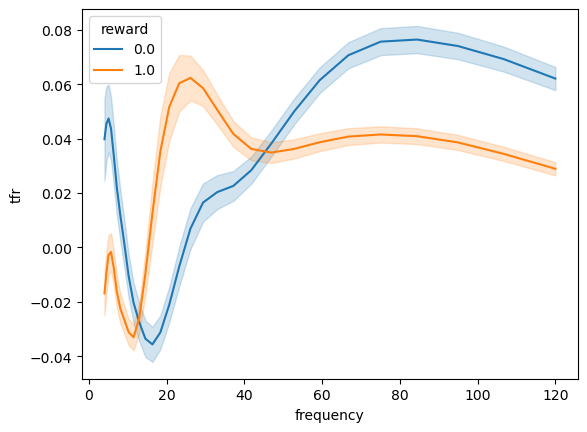

In [46]:
sns.lineplot(data=chan_dfs, x='frequency', y='tfr', hue='reward', errorbar='se')




## Statistical Analyses of TFRs:

At this stage, you should **heavily** brainstorm the statistics you want to do, before you start writing any code. What is the goal of your analysis? What would actually allow you to show what you want to show?

## One-sample cluster permutation test


A one sample cluster permutation test measures whether a spectrogram differs significantly from a particular mean (typically 0). 

  0%|          | Permuting : 0/499 [00:00<?,       ?it/s]

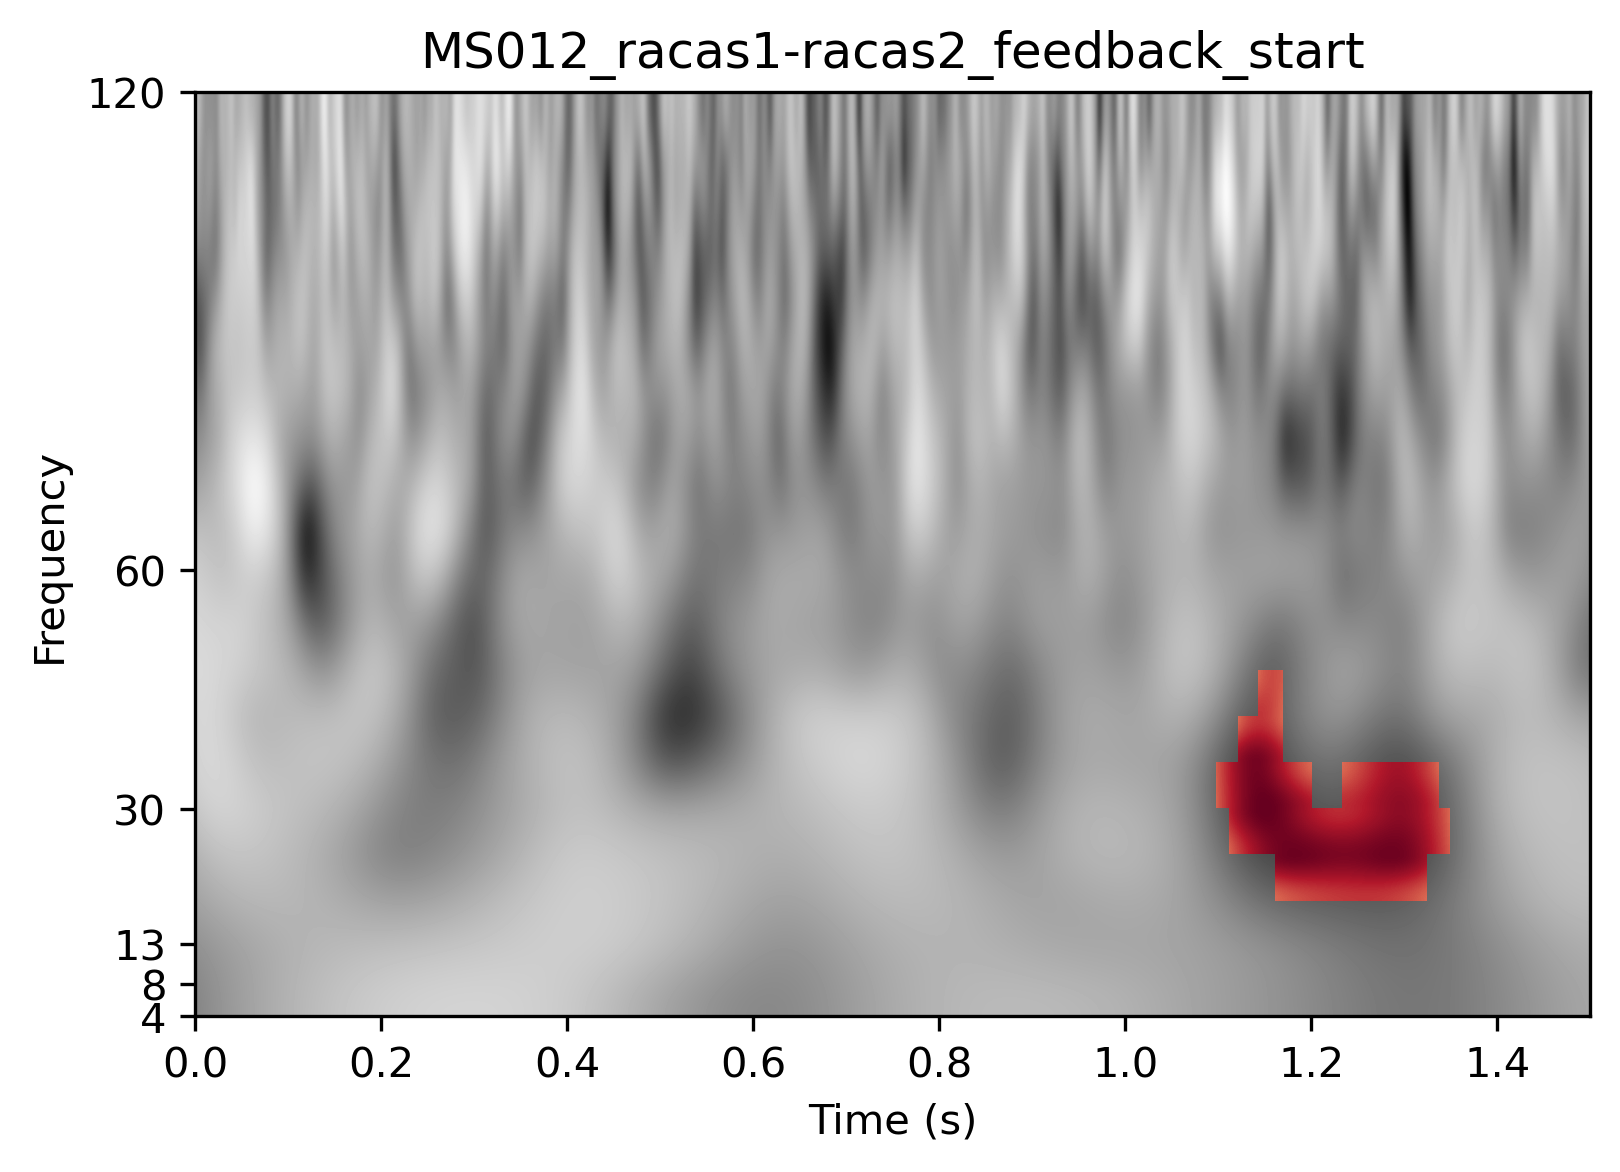

In [66]:
subj_id = 'MS012'
# region = 'frontal'

# save_path = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}'
# # Get electrode df 
# elec_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/anat/'
# # electrode files could either be csv or excel
# elec_files = glob(f'{elec_path}/*.csv') + glob(f'{elec_path}/*.xlsx')
# # There should really only be one 
# elec_file = elec_files[0]
# elec_data = lfp_preprocess_utils.load_elec(elec_file)

# anode_list = [x.split('-')[0] for x in epochs_all_subjs_all_evs[subj_id][event].ch_names]
# elec_df = elec_data[elec_data.label.str.lower().isin(anode_list)]
# # Shawn noticed the following would incorrectl y label electrodes if they're not in the same order as .ch_names! 
# # elec_df['label'] = epochs_all_subjs_all_evs[subj_id][event].ch_names
# # Fix: 
# elec_df['label'] = elec_df['label'].apply(lambda x: next((string for string in epochs_all_subjs_all_evs[subj_id][event].ch_names if x in string), np.nan))
    
# picks = analysis_utils.select_picks_rois(elec_df, region)

for event in analysis_evs:
    
    # Average the data in each condition across channels 
    X = np.nanmean(power_epochs[subj_id][event].copy().pick_channels([chan]).data, axis=1)
    
    F_obs, clusters, cluster_p_values, H0 = \
    mne.stats.permutation_cluster_1samp_test(X, n_permutations=500, out_type='mask', verbose=True)
    
    if any(cluster_p_values<=0.05):
#     print(region)
        # Create new stats image with only significant clusters
        fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)

        times =  power_epochs[subj_id][event].times


        # Average the data in each condition across epochs for plotting
        evoked_power = np.nanmean(X, axis=0)
    #     evoked_power_2 = np.nanmean(X[1], axis=0)
    #     evoked_power_contrast = evoked_power_1 - evoked_power_2
        signs = np.sign(evoked_power)

        F_obs_plot = np.nan * np.ones_like(F_obs)
        for c, p_val in zip(clusters, cluster_p_values):
            if p_val <= 0.05:
                F_obs_plot[c] = F_obs[c] * signs[c]

        ax.imshow(F_obs,
                  extent=[times[0], times[-1], freqs[0], freqs[-1]], interpolation = 'Bicubic',
                  aspect='auto', origin='lower', cmap='gray')
        max_F = np.nanmax(abs(F_obs_plot))
        ax.imshow(F_obs_plot,
                  extent=[times[0], times[-1], freqs[0], freqs[-1]],
                  aspect='auto', origin='lower', cmap='RdBu_r',
                  vmin=-max_F, vmax=max_F)

        ax.set(yticks=yticks, xlabel='Time (s)', ylabel='Frequency', title=f'{subj_id}_{chan}_{event}')

            # # ax.set_title(f'Induced power ({ch_name})')
    
    

## Two-sample cluster-permutation test 

A two sample cluster permutation test compares the spectrograms between two different task conditions. As an example, let's say I want to compare the positive RPE vs. negative RPE conditions for every channel.

In [67]:
subj_id = 'MS012'
# region = 'frontal'

# save_path = f'{base_dir}/work/qasims01/MemoryBanditData/EMU/Subjects/{subj_id}'
# # Get electrode df 
# elec_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/anat/'
# # electrode files could either be csv or excel
# elec_files = glob(f'{elec_path}/*.csv') + glob(f'{elec_path}/*.xlsx')
# # There should really only be one 
# elec_file = elec_files[0]
# elec_data = lfp_preprocess_utils.load_elec(elec_file)

# anode_list = [x.split('-')[0] for x in epochs_all_subjs_all_evs[subj_id][event].ch_names]
# elec_df = elec_data[elec_data.label.str.lower().isin(anode_list)]
# # Shawn noticed the following would incorrectly label electrodes if they're not in the same order as .ch_names! 
# # elec_df['label'] = epochs_all_subjs_all_evs[subj_id][event].ch_names
# # Fix: 
# elec_df['label'] = elec_df['label'].apply(lambda x: next((string for string in epochs_all_subjs_all_evs[subj_id][event].ch_names if x in string), np.nan))

    
# picks = analysis_utils.select_picks_rois(elec_df, region)

# task condition to contrast 
conditions = ['reward==0',
             'reward==1']

for event in analysis_evs:
    
    # Average the data in each condition across channels 
    X = [np.nanmean(power_epochs[subj_id][event][conditions[0]].copy().pick_channels([chan]).data, axis=1), 
         np.nanmean(power_epochs[subj_id][event][conditions[1]].copy().pick_channels([chan]).data, axis=1)]
    
    F_obs, clusters, cluster_p_values, H0 = \
    mne.stats.permutation_cluster_test(X, n_permutations=500, out_type='mask', verbose=True)
    
    if any(cluster_p_values<=0.05):
        # Create new stats image with only significant clusters
        fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)

        times =  power_epochs[subj_id][event].times


        # Average the data in each condition across epochs for plotting
        evoked_power_1 = np.nanmean(X[0], axis=0)
        evoked_power_2 = np.nanmean(X[1], axis=0)
        evoked_power_contrast = evoked_power_1 - evoked_power_2
        signs = np.sign(evoked_power_contrast)

        F_obs_plot = np.nan * np.ones_like(F_obs)
        for c, p_val in zip(clusters, cluster_p_values):
            if p_val <= 0.05:
                F_obs_plot[c] = F_obs[c] * signs[c]

        ax.imshow(F_obs,
                  extent=[times[0], times[-1], freqs[0], freqs[-1]], interpolation = 'Bicubic',
                  aspect='auto', origin='lower', cmap='gray')
        max_F = np.nanmax(abs(F_obs_plot))
        ax.imshow(F_obs_plot,
                  extent=[times[0], times[-1], freqs[0], freqs[-1]],
                  aspect='auto', origin='lower', cmap='RdBu_r',
                  vmin=-max_F, vmax=max_F)

        ax.set(yticks=yticks, xlabel='Time (s)', ylabel='Frequency', title=f'{subj_id}_{chan}_{cond_name}_{event}')

        # # ax.set_title(f'Induced power ({ch_name})')
    
    

/tmp/ipykernel_81626/1780731117.py:34: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  mne.stats.permutation_cluster_test(X, n_permutations=500, out_type='mask', verbose=True)


  0%|          | Permuting : 0/499 [00:00<?,       ?it/s]

In [70]:
cluster_p_values.shape

(42,)

## Time-resolved regression

In [320]:
regressors = mne_data_reref.metadata[['reward', 'gamble']]

In [321]:
timeseries = mne_data_reref._data[:, 0, :]
regressors = mne_data_reref.metadata[['reward', 'gamble']]
win_len = 200
slide_len = 50
# Smooth the timeseries 
smoothed_data = np.zeros([timeseries.shape[0], (timeseries.shape[1] // slide_len) - (win_len//slide_len - 1)])
for trial in range(timeseries.shape[0]):
    smoothed_data[trial, :] = [np.nanmean(timeseries[trial, i:i+win_len]) for i in range(0, timeseries.shape[1], slide_len) if i+win_len <= timeseries.shape[1]]

# Run the regression
models = []
for ts in range(smoothed_data.shape[1]): 
    model_df = regressors.copy() 
    model_df['dv'] = smoothed_data[:, ts]
    formula = f'dv ~ 1+'+'+'.join(regressors.columns)
    mod = smf.glm(formula=formula, data=model_df, family=sm.families.Gaussian()).fit()
    models.append(pd.DataFrame(mod.params).T)

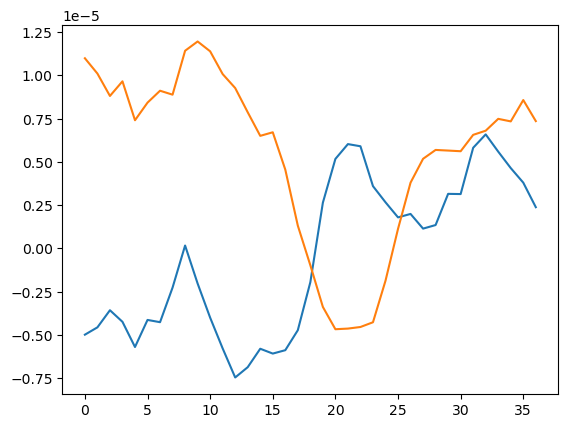

In [322]:
plt.plot(pd.concat(models).reward.values)
plt.plot(pd.concat(models).gamble.values)

## Empirical mode decomposition for cycle/burst detection (WIP)

The benefit of EMD is that we get away from assumptions of sinuisoidal oscillations and linearity in the time-series. 

TODO: turn this into analysis!

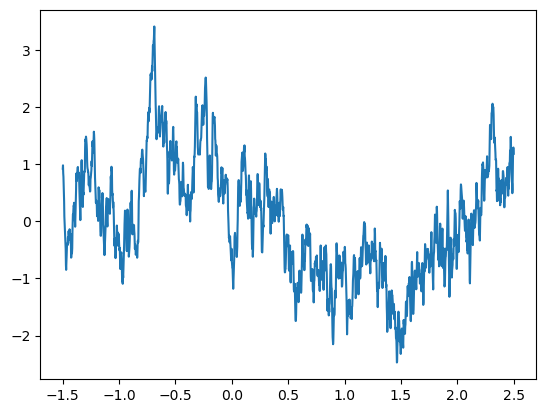

In [83]:
# Zscore the data first (idk why, but otherwise unable to plot IMFs) 

test_epoch = zscore(feedback_epochs_reref._data[0, 26, :])
time_vect = feedback_epochs_reref.times
sample_rate = int(feedback_epochs_reref.info['sfreq'])
plt.plot(time_vect, test_epoch)

<AxesSubplot:xlabel='Time (samples)'>

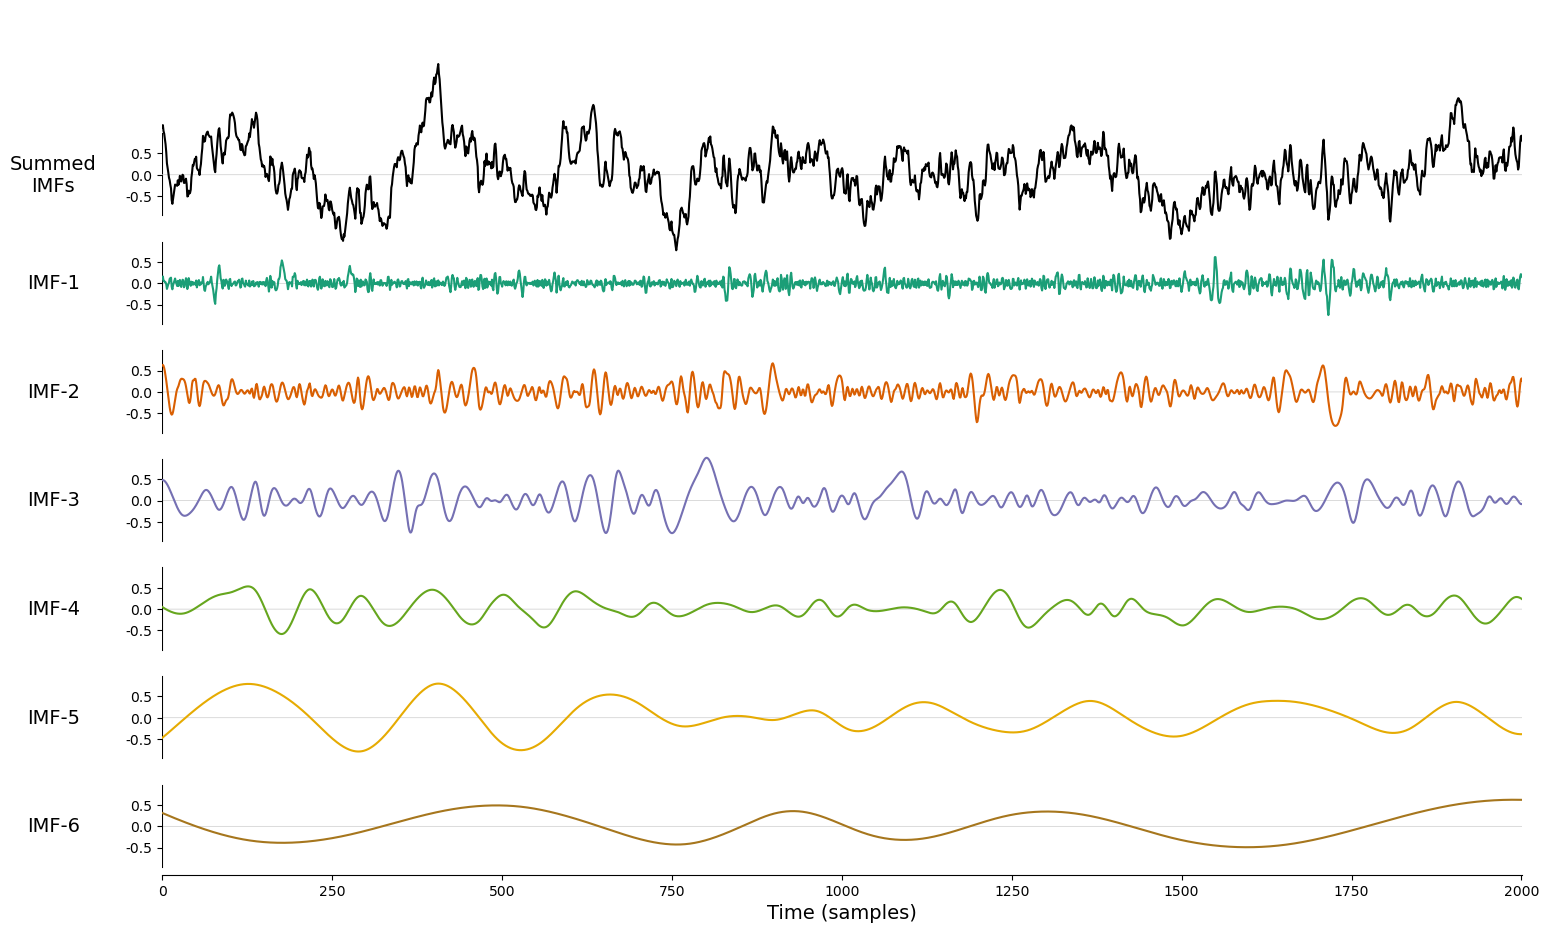

In [84]:
imf = emd.sift.sift(test_epoch, max_imfs=6)
# Visualise the IMFs
emd.plotting.plot_imfs(imf)

Here, it looks like IMF-2 might have some meaningful oscillatory bursts in it

from the IMFs, compute the instantaneous frequency, phase and amplitude using the Normalised Hilbert Transform Method

In [85]:
IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert')
# Extract cycle locations
all_cycles = emd.cycles.get_cycle_vector(IP, return_good=False)
good_cycles = emd.cycles.get_cycle_vector(IP, return_good=True)

# ``all_cycles`` is an array of the same size as the input instantaneous phase.
# Each row contains a vector of itegers indexing the location of successive
# cycles for that IMF.

# Set a 33% amplitude threshold on IMF-1 

thresh = np.percentile(IA[:, 1], 33)
mask = IA[:, 1] > thresh

mask_cycles = emd.cycles.get_cycle_vector(IP, return_good=True, mask=mask)

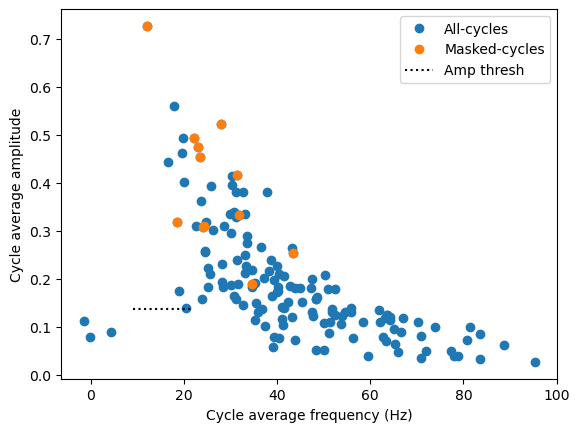

In [86]:

# Compute cycle average frequency for all cycles and masked cycles
all_cycle_freq = emd.cycles.get_cycle_stat(all_cycles[:, 1], IF[:, 1], func=np.mean)
mask_cycle_freq = emd.cycles.get_cycle_stat(mask_cycles[:, 1], IF[:, 1], func=np.mean)

# Compute cycle frequency range for all cycles and for masked cycles
all_cycle_amp = emd.cycles.get_cycle_stat(all_cycles[:, 1], IA[:, 1], func=np.mean)
mask_cycle_amp = emd.cycles.get_cycle_stat(mask_cycles[:, 1], IA[:, 1], func=np.mean)

# Make a summary figures
plt.figure()
plt.plot(all_cycle_freq, all_cycle_amp, 'o')
plt.plot(mask_cycle_freq, mask_cycle_amp, 'o')
plt.xlabel('Cycle average frequency (Hz)')
plt.ylabel('Cycle average amplitude')
plt.plot((9, 22), (thresh, thresh), 'k:')
plt.legend(['All-cycles', 'Masked-cycles', 'Amp thresh'])

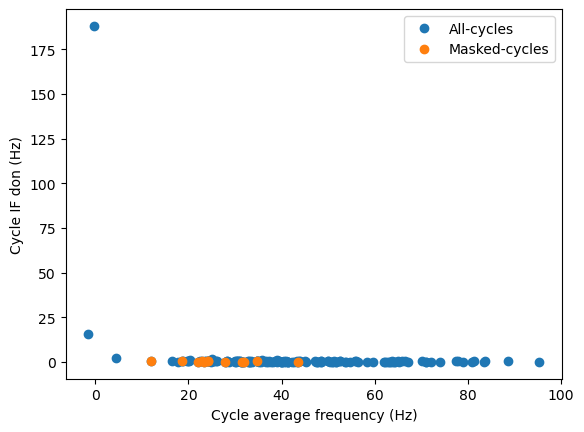

In [87]:
# Compute cycle average frequency for all cycles and masked cycles
all_cycle_freq = emd.cycles.get_cycle_stat(all_cycles[:, 1], IF[:, 1], func=np.mean)
mask_cycle_freq = emd.cycles.get_cycle_stat(mask_cycles[:, 1], IF[:, 1], func=np.mean)


# Define a simple function to compute the range of a set of values
def degree_nonlinearity(x):
    return np.std((x - x.mean()) / x.mean())


# Compute cycle freuquency range for all cycles and for masked cycles
all_cycle_freq_don = emd.cycles.get_cycle_stat(all_cycles[:, 1], IF[:, 1],
                                               func=degree_nonlinearity)
cycle_freq_don = emd.cycles.get_cycle_stat(mask_cycles[:, 1], IF[:, 1],
                                           func=degree_nonlinearity)

# Make a summary figures
plt.figure()
plt.plot(all_cycle_freq, all_cycle_freq_don, 'o')
plt.plot(mask_cycle_freq, cycle_freq_don, 'o')
plt.xlabel('Cycle average frequency (Hz)')
plt.ylabel('Cycle IF don (Hz)')
plt.legend(['All-cycles', 'Masked-cycles'])

In [88]:
C = emd.cycles.Cycles(IP[:, 1])


In [89]:
C.compute_cycle_metric('max_amp', IA[:, 1], func=np.max)
# Compute the length of each cycle
C.compute_cycle_metric('duration', IA[:, 1], len)


In [90]:
df = C.get_metric_dataframe()
print(df)

     is_good   max_amp  duration
0          0  0.701304        21
1          0  0.372257        22
2          1  0.385533        16
3          1  0.308479        21
4          0  0.342624        19
..       ...       ...       ...
142        0  0.176165         7
143        1  0.216235        15
144        0  0.313112        14
145        0  0.414475        16
146        0  0.471747         5

[147 rows x 3 columns]


(0.0, 60.0)

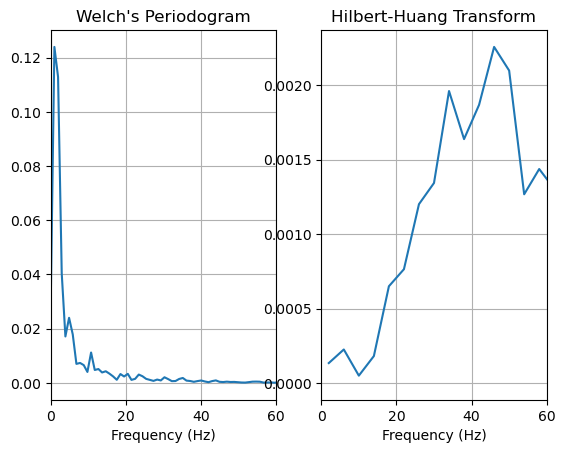

In [91]:
from scipy import signal 
fft_f, pxx_linear = signal.welch(test_epoch, fs=sample_rate, nperseg=512)

# Summary figure
plt.figure()
plt.subplot(121)
plt.plot(fft_f, pxx_linear)
plt.title("Welch's Periodogram")
# plt.xlim(0, 20)
# plt.xticks(np.arange(10)*2)
plt.grid(True)
plt.xlabel('Frequency (Hz)')

# Hilbert-Huang transform
freq_range = (0, 256, 64)
hht_f, spec_linear = emd.spectra.hilberthuang(IF, IA, freq_range, scaling='density', sum_imfs=False)

plt.xlim(0, 60)
plt.subplot(122)
plt.plot(hht_f, spec_linear[:, 0])
# plt.xticks(np.arange(10)*2)
plt.grid(True)
plt.title("Hilbert-Huang Transform")
plt.xlabel('Frequency (Hz)')
plt.xlim(0, 60)

In [355]:
fft_f.shape

(257,)

From the instantaneous frequency and amplitude, we can compute the Hilbert-Huang spectrum:



In [95]:
# Define frequency range (low_freq, high_freq, nsteps, spacing)
freq_range = np.logspace(*np.log10([4, 120]), num=20)
f, hht = emd.spectra.hilberthuang(IF, IA, freq_range, sum_time=False)

In [98]:
fig = plt.figure(figsize=(10, 6))
emd.plotting.plot_hilberthuang(hht, time_vect, f,
                               time_lims=(-0.5, 1.5),
                               fig=fig, log_y=True, cmap='RdBu_r')

TypeError: plot_hilberthuang() got an unexpected keyword argument 'interpolation'

<Figure size 1000x600 with 0 Axes>

In [99]:
emd.plotting.plot_hilberthuang?